## LT の表記揺れについて

In [1]:
import numpy as np
import pandas as pd
import json
import gensim
import collections
import matplotlib.pyplot as plt
import pprint
import itertools
import re
import seaborn as sns
import networkx as nx
from IPython.display import display_svg
import tqdm
%matplotlib inline

In [2]:
with open("./lt.json", "r") as f:
    raw_lt = json.load(f)

In [3]:
with open("./vyos_logs/tpl_all_uniq", "r") as f:
    raw_vyos = f.readlines()

In [4]:
def camelToSnake(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

def remove_last_symbol(value):
    if len(value) == 1:
        if not value.isalnum():
            return ''
        else:
            return value
    elif value[-1].isalnum():
        return value
    else:
        return remove_last_symbol(value[:-1])

In [230]:
def remove_symbols(value):
    v = value.replace('\n', ' ').replace('\\n', ' ')
    v = v.replace('\\r', ' ').replace('\\t', ' ' )
    v = v.replace('-', ' ').replace('+', '').replace("'",'').replace('"', '').replace('>','').replace('<','').replace('=',' ').replace('(', '').replace(')', '').replace('[', '').replace(']', '').replace('*', '').replace('**', '').replace(':', '').replace(',', '').replace("_", " ")
    v = v.replace('\\', ' ').replace("\t", ' ')
    v = camelToSnake(v)
    v = v.replace('_', ' ')
    return v
    
def string_to_corpus(lt, max_len=None, use_spdict=False):
    words = [remove_symbols(t) for t in lt.split()]
    split_words = []
    for w in words:
        if len(w.split()) > 1: # さらに分割できる場合
            split_words.extend(w.split())
        else:
            split_words.append(w)
            
            
    split_words = [remove_last_symbol(t) for t in split_words if t != '']
    split_words = [t.lower() for t in split_words if t != '']
    split_words = [WordNetLemmatizer().lemmatize(t, 'v') for t in split_words]
    
    ## validate NNS or specific word
    ## e.g., avoiding "junos" -> "juno" 
    tmp = []
    for t in split_words:
        if nltk.pos_tag(t)[0][1] == "NNS" and (t not in lemmataize_blacklist):
            t = WordNetLemmatizer().lemmatize(t)
        tmp.append(t)
    split_words = tmp
            
    if use_spdict:
        ## use specific word dict
        tmp = []
        for t in split_words:
            if t in junos_specific_word_dict:
                converted_word = junos_specific_word_dict[t]
                if type(converted_word) == list:
                    tmp.extend(converted_word)
                else:
                    tmp.append(converted_word)
            else:
                tmp.append(t)
        split_words = tmp
    
    if max_len != None:
        split_words = split_words[:max_len] # 前方のみ残す

    return split_words

In [49]:
lt_per_cat = {}
for ltid, value in raw_lt.items():
    if value['cat'] not in lt_per_cat:
        lt_per_cat[value['cat']] = [value['lt']]
    else:
        lt_per_cat[value['cat']].append(value['lt'])

In [50]:
words_per_cat = dict()
for cat, lts in lt_per_cat.items():
    corpus = []
    for lt in lts:
        words = [remove_symbols(t) for t in lt.split()]
        split_words = []
        for w in words:
            if len(w.split()) > 1: # さらに分割できる場合
                split_words.extend(w.split())
            else:
                split_words.append(w)
            
        split_words = [remove_last_symbol(t) for t in split_words if t != '']
        split_words = [t.lower() for t in split_words if t != '']
        corpus.extend(split_words)
    words_per_cat[cat] = corpus

In [51]:
all_words = list(set([word for cat, words in words_per_cat.items() for word in words]))
word2id = {w:i for i, w in enumerate(all_words)}
id2word = {v:k for k,v in word2id.items()}

corpus = []
for cat, lts in lt_per_cat.items():
    for lt in lts:
        words = [remove_symbols(t) for t in lt.split()]
        split_words = []
        for w in words:
            if len(w.split()) > 1: # さらに分割できる場合
                split_words.extend(w.split())
            else:
                split_words.append(w)
                
        split_words = [remove_last_symbol(t) for t in split_words if t != '']
        split_words = [t.lower() for t in split_words if t != '']
        
        split_words = split_words[:10] # 前方のみ残す
        
        lt_word_id_cnt = collections.Counter([word2id[w] for w in split_words])
        
        corpus.append([(tid, cnt) for tid, cnt in lt_word_id_cnt.items()])

In [53]:
for w in all_words:
    if nltk.pos_tag([w])[0][1] == "NNS" :
        print(nltk.pos_tag([w]))

[('versions', 'NNS')]
[('instances', 'NNS')]
[('entries', 'NNS')]
[('caps', 'NNS')]
[('handles', 'NNS')]
[('clients', 'NNS')]
[('targets', 'NNS')]
[('systems', 'NNS')]
[('rts', 'NNS')]
[('seconds', 'NNS')]
[('events', 'NNS')]
[('overwritten', 'NNS')]
[('pics', 'NNS')]
[('junos', 'NNS')]
[('eth', 'NNS')]
[('commands', 'NNS')]
[('/kernel', 'NNS')]
[('fgets', 'NNS')]
[('fans', 'NNS')]
[('devices', 'NNS')]
[('media', 'NNS')]
[('interfaces', 'NNS')]
[('domains', 'NNS')]
[('perms', 'NNS')]
[('ports', 'NNS')]
[('frames', 'NNS')]
[('contains', 'NNS')]
[('troubles', 'NNS')]
[('addresses', 'NNS')]
[('links', 'NNS')]
[('tests', 'NNS')]
[('prefers', 'NNS')]
[('channel', 'NNS')]
[('bytes', 'NNS')]
[('sms', 'NNS')]
[('times', 'NNS')]
[('samples', 'NNS')]
[('groups', 'NNS')]
[('impellers', 'NNS')]
[('contents', 'NNS')]
[('unrefs', 'NNS')]
[('policies', 'NNS')]
[('rules', 'NNS')]
[('failures', 'NNS')]
[('claims', 'NNS')]
[('states', 'NNS')]
[('blocks', 'NNS')]
[('delayed', 'NNS')]
[('servers', 'NNS')]

In [179]:
lemmataize_blacklist = ['sms', 'junos', 'cubs', 'caps', 'pics', 'ns', 'gres', 'libjunos', 'tos']

- 文末のドット

In [58]:
import nltk
from nltk.stem.wordnet import WordNetLemmatizer

In [ ]:
nltk.help.upenn_tagset()

In [59]:
## open junos specific word dic

with open('processed_junos_words.txt', 'r') as f:
    t = f.readlines()

junos_specific_word_dict = {}
for s in t:
    k = s.strip().split(" : ")[0]
    if len(s.strip().split(" : ")) == 1 :
        v = ""
    else:
        v = s.strip().split(" : ")[1].split()
        
    junos_specific_word_dict[k] = v

In [ ]:
# all_base_words = []
# for word in sorted(all_words):
#     word = WordNetLemmatizer().lemmatize(word, 'n')
#     all_base_words.append(WordNetLemmatizer().lemmatize(word, 'v'))

# for idx, word in enumerate(sorted(set(all_base_words))):
#     word2id = {w:i for i, w in enumerate(all_words)}
#     id2word = {v:k for k,v in word2id.items()}

In [60]:
lt_per_cat = {}
for ltid, value in raw_lt.items():
    if value['cat'] not in lt_per_cat:
        lt_per_cat[value['cat']] = [value['lt']]
    else:
        lt_per_cat[value['cat']].append(value['lt'])

In [62]:
words_per_cat = dict()
for cat, lts in lt_per_cat.items():
    corpus = []
    for lt in lts:
        words = [remove_symbols(t) for t in lt.split()]
        split_words = []
        for w in words:
            if len(w.split()) > 1: # さらに分割できる場合
                split_words.extend(w.split())
            else:
                split_words.append(w)
            
        split_words = [remove_last_symbol(t) for t in split_words if t != '']
        split_words = [t.lower() for t in split_words if t != '']
        split_words = [WordNetLemmatizer().lemmatize(t, 'v') for t in split_words]
        
        ## validate NNS or specific word
        ## e.g., avoiding "junos" -> "juno" 
        tmp = []
        for t in split_words:
            if nltk.pos_tag(t)[0][1] == "NNS" and (t not in lemmataize_blacklist):
                t = WordNetLemmatizer().lemmatize(t)
            tmp.append(t)
        split_words = tmp
        
        ## use specific word dict
        tmp = []
        for t in split_words:
            if t in junos_specific_word_dict:
                converted_word = junos_specific_word_dict[t]
                if type(converted_word) == list:
                    tmp.extend(converted_word)
                else:
                    tmp.append(converted_word)
            else:
                tmp.append(t)
#         print(split_words, '\n', tmp, '\n')
        split_words = tmp

        corpus.extend(split_words)
    words_per_cat[cat] = corpus

In [64]:
all_words = list(set([word for cat, words in words_per_cat.items() for word in words]))
word2id = {w:i for i, w in enumerate(all_words)}
id2word = {v:k for k,v in word2id.items()}

corpus = []
for cat, lts in lt_per_cat.items():
    for lt in lts:
        words = [remove_symbols(t) for t in lt.split()]
        split_words = []
        for w in words:
            if len(w.split()) > 1: # さらに分割できる場合
                split_words.extend(w.split())
            else:
                split_words.append(w)
                
        split_words = [remove_last_symbol(t) for t in split_words if t != '']
        split_words = [t.lower() for t in split_words if t != '']
        split_words = [WordNetLemmatizer().lemmatize(t, 'v') for t in split_words]

        ## validate NNS or specific word
        ## e.g., avoiding "junos" -> "juno" 
        tmp = []
        for t in split_words:
            if nltk.pos_tag(t)[0][1] == "NNS" and (t not in lemmataize_blacklist):
                t = WordNetLemmatizer().lemmatize(t)
            tmp.append(t)
        split_words = tmp
            
        ## use specific word dict
        ## e.g., "cmd" -> "command"
        tmp = []
        for t in split_words:
            if t in junos_specific_word_dict:
                converted_word = junos_specific_word_dict[t]
                if type(converted_word) == list:
                    tmp.extend(converted_word)
                else:
                    tmp.append(converted_word)
            else:
                tmp.append(t)
        split_words = tmp
        
        split_words = split_words[:10] # 前方のみ残す
        
        lt_word_id_cnt = collections.Counter([word2id[w] for w in split_words])
        
        corpus.append([(tid, cnt) for tid, cnt in lt_word_id_cnt.items()])

In [ ]:
# with open("processed_junos_words.txt", "w") as f:
#     for w in sorted(all_words):
#         f.write(w)
#         f.write('\n')

In [65]:
# 単語のカウント
word_cnt = {}
for wid, cnt in sorted(collections.Counter([c[0] for s in corpus for c in s]).items(), key= lambda x: x[1])[::-1]:
    print(id2word[wid], '\t', cnt)
    word_cnt[id2word[wid]] = cnt

user 	 545
ui 	 543
mgd 	 505
configuration 	 490
audit 	 466
rpd 	 376
set 	 334
event 	 260
other 	 257
index 	 184
broadcast 	 168
to 	 167
up 	 163
multicast 	 158
delete 	 139
on 	 125
bgp 	 119
options 	 118
protocols 	 118
from 	 106
logical 	 100
route 	 100
address 	 99
down 	 96
/kernel 	 92
lsp 	 89
mpls 	 85
for 	 84
systems 	 82
group 	 81
receive 	 68
interfaces 	 65
policy 	 63
initialise 	 62
be 	 62
login 	 62
send 	 61
error 	 59
as 	 58
change 	 58
primary 	 54
family 	 53
port 	 53
class 	 51
of 	 51
pfe 	 50
mtu 	 48
add 	 46
fail 	 46
state 	 45
system 	 45
host 	 44
connection 	 43
interface 	 43
chassisd 	 42
snmp 	 42
trap 	 42
fpc 	 42
file 	 42
pic 	 42
alarm 	 41
task 	 41
read 	 40
config 	 40
message 	 40
mcsn 	 39
peer 	 38
command 	 38
instance 	 37
link 	 37
point 	 37
notification 	 36
unit 	 35
client 	 35
power 	 34
xntpd 	 34
code 	 33
pid 	 33
status 	 33
no 	 32
ospf 	 31
clear 	 31
not 	 31
secondary 	 30
neighbor 	 30
forward 	 30
slot 	 29
gene

In [ ]:
# LTレベルの共起
cor_df = pd.DataFrame(index=np.arange(len(word2id)), columns=np.arange(len(word2id)), dtype=int)
cor_df = cor_df.fillna(0)

for s in corpus:
    for a,b in itertools.combinations(s, 2):
        ida = int(a[0])
        idb = int(b[0])
        cor_df[ida][idb] += 1
        cor_df[idb][ida] += 1

cor_list = []
for a,b in itertools.combinations(np.arange(len(word2id)), 2):
    if cor_df[a][b] != 0 :
        cor_list.append([(a, b) , cor_df[a][b]])
        
for i in tqdm.tqdm(sorted(cor_list, key=lambda x:x[1], reverse=True)):
    a,b = i[0]
    print(id2word[a], id2word[b], i[1])
    print("\t simpson:", i[1]/min(word_cnt[id2word[a]], word_cnt[id2word[b]]))
    print("\t jaccard:", i[1]/(word_cnt[id2word[a]] + word_cnt[id2word[b]] - i[1]))
    print()

In [ ]:
G = nx.DiGraph()
nx.set_node_attributes

for i in sorted(cor_list, key=lambda x:x[1], reverse=True):
    if i[1] > 9: # 共起が10回以上
        a,b = i[0]
        simpson = i[1]/min(word_cnt[id2word[a]], word_cnt[id2word[b]])
        jaccard = i[1]/(word_cnt[id2word[a]] + word_cnt[id2word[b]] - i[1])
        
        print(simpson)
        if simpson > 0.7:
            if a not in G.nodes:
                G.add_node(id2word[a])

            if b not in G.nodes:
                G.add_node(id2word[b])

            src = id2word[a] if np.argmin([word_cnt[id2word[a]], word_cnt[id2word[b]]]) == 0 else id2word[b]
            dst = id2word[a] if src == id2word[b] else id2word[b]
            G.add_edge(src, dst, weight=jaccard)

In [ ]:
json_data = nx.node_link_data(G)
f = open("nx.json", "w")
json.dump(json_data, f, ensure_ascii=False, indent=4, sort_keys=True, separators=(',', ': '))
f.close()

In [ ]:
plt.figure(figsize=(13, 13))
nx.draw_networkx(G, pos=nx.shell_layout(G))
plt.show()

## LDA

In [66]:
for cat, lts in lt_per_cat.items():
    print(cat)

system(cron)
network(lacp)
service(ntp)
monitor(syslog)
network(mtu)
mgmt(login)
system(ui)
mgmt(command)
mgmt(ssh)
network(l2)
system(unix)
network(storm)
system(pic)
network(pfe)
system(ppe)
mgmt(pam)
mgmt(su)
egp(bgp)
network(mld)
system(fpc)
network(arp)
interface(port)
mgmt(config)
interface(agg)
monitor(snmp)
interface(if_event)
interface(vlan)
mgmt(enable)
vpn(mpls)
network(stp)
igp(ospf)
network(rsvp)
vpn(l2vc)
vpn(vpls)
network(tcp)
system(fan)
mgmt(ftp)
network(sfp)
system(power)
system(system_conf)
network(socket)
system(tnp)
system(alarm)
system(gres)
network(pim)
egp(msdp)
interface(interface)
system(others)
system(config_apply)
mgmt(config_process)
network(routing)
mgmt(ui_error)
system(None)
system(cos)
system(ppm)
monitor(bfd)
system(lisence)
network(icmp)
system(csu)
system(boot)
system(pci)
interface(inet6)
network(lldp)
network(mcsnoop)


In [67]:
STOP_WORDS = [word2id[i] for i in ['and', 'of', 'from', 'to', 'in', 'on', 'for']]

In [68]:
tmp = []
eval_corpus = []
eval_corpus_ltids = []

for ltid, i in enumerate(corpus):
    if word2id['ui'] not in [j[0] for j in i]: # uiを弾く
        i = [j for j in i if j[0] not in STOP_WORDS]
        tmp.append(tuple(sorted(i)))
        eval_corpus.append(i)
        eval_corpus_ltids.append(ltid)
    
set_corpus2 = list(set(tmp))

E stepとM step を172回やっている

In [69]:
junos_lda = gensim.models.ldamodel.LdaModel(
                                      corpus=set_corpus2,
                                      chunksize=5,
                                      num_topics=40, 
                                      id2word=id2word, 
                                      minimum_probability=1e-8, 
                                      #gamma_threshold=1e-5,
                                      #eval_every=10,
                                      iterations=100,
#                                       alpha='auto', 
#                                       eta='auto', 
                                      decay=1.0,
                                      passes=1,
                                      per_word_topics=True)

In [70]:
results =  [np.argmax(l) for l in junos_lda.inference(eval_corpus)[0]]

inference_results = {}
for a,b in zip(eval_corpus, results):
    if b in inference_results:
        inference_results[b].append([id2word[c[0]] for c in a])
    else:
        inference_results[b] = [[id2word[c[0]] for c in a]]

In [72]:
inf_topic_words = {}
for topic in range(junos_lda.num_topics):
    print(topic, [id2word[i[0]] for i in junos_lda.get_topic_terms(topic)])
    inf_topic_words[topic] = [id2word[i[0]] for i in junos_lda.get_topic_terms(topic)]

0 ['re', 'master', 'with', 'minor', 'id', 'l2', 'backup', 'stream', 'modem', 'communication']
1 ['notification', 'code', 'proto', 'pp', 'cease', 'cap', 'hold', 'plane', 'ksyncd', 'control']
2 ['/kernel', 'mac', 'group', 'start', 'channel', 'call', 'local', 'jsr', 'socket', 'source']
3 ['message', 'snmpd', 'queue', 'authenticate', 'size', 'throttle', 'v', 'allocate', 'vq', 'lose']
4 ['complete', 'version', 'tnp', 'ethernet', 'jspec', 'bootpd', 'tftpd', 'switch', 'duplicate', 'asic']
5 ['mpls', 'lsp', 'route', 'primary', 'secondary', 'path', 'eventd', 'initiate', 'download', 'sent']
6 ['event', 'index', 'broadcast', 'multicast', 'mcsn', 'point', 'mtu', 'bandwidth', 'nif', 'initialize']
7 ['by', 'sshd', 'disconnect', 'request', 'server', 'vccpd', 'close', 'build', 'router', 'builder']
8 ['trap', 'snmp', 'pc', 'hardware', 'ppe', 'snmpd', 'count', 'fault', 'generate', 'drain']
9 ['change', 'time', 'xntpd', 'bundle', 'ae', 'ntp', 's', 'ntpd', 'out', 'synchronize']
10 ['su', 'take', 'ie', 'co

In [ ]:
inf_topic_words = {}
for topic in range(junos_lda.num_topics):
    print(topic, [id2word[i[0]] for i in junos_lda.get_topic_terms(topic)])
    inf_topic_words[topic] = [id2word[i[0]] for i in junos_lda.get_topic_terms(topic)]

### eval

- 外れたやつについて，調査

In [ ]:
for a,b in lt_per_cat.items():
    print(a, len(b))

In [ ]:
## show results

inf_per_cat = {}
for cat,lts in lt_per_cat.items():
    print(cat)
    inf_per_cat[cat] = []
    for lt in lts:
        c = list(collections.Counter([word2id[w] for w in string_to_corpus(lt, max_len=7, use_spdict=True)]).items())
        topic_dist, word_topic, word_topic_dist = junos_lda[c]
        inf_topic = np.argmax(np.array([t[1] for t in topic_dist]))
        inf_per_cat[cat].append(inf_topic)
        print("\t", inf_topic, ",", lt)

In [ ]:
## show results

inf_per_cat = {}
for cat,lts in lt_per_cat.items():
    print(cat)
    inf_per_cat[cat] = []
    for lt in lts:
        c = list(collections.Counter([word2id[w] for w in string_to_corpus(lt, max_len=7)]).items())
        topic_dist, word_topic, word_topic_dist = junos_lda[c]
        inf_topic = np.argmax(np.array([t[1] for t in topic_dist]))
        inf_per_cat[cat].append(inf_topic)
        print("\t", inf_topic, ",", lt)

In [ ]:
## show detailed results

inf_per_cat = {}
for cat,lts in lt_per_cat.items():
    print(cat)
    inf_per_cat[cat] = []
    for lt in lts:
        print(lt)
        c = list(collections.Counter([word2id[w] for w in string_to_corpus(lt, max_len=7)]).items())
        topic_dist, word_topic, word_topic_dist = junos_lda[c]
        inf_topic = np.argmax(np.array([t[1] for t in topic_dist]))
        inf_per_cat[cat].append(inf_topic)
        print("\t", inf_topic)
        print("\t", inf_topic_words[inf_topic])
        print("\t"+"-"*10)
        for w in word_topic_dist:
            print("\t", id2word[w[0]], w[1])
        print()

In [ ]:
## 推定トピック別のLT

lt_per_inf_topic = {}
for i in range(40):
    lt_per_inf_topic[i] = []
    
for ltid, data in raw_lt.items():
    lt = data['lt']
        
    c = list(collections.Counter([word2id[w] for w in string_to_corpus(lt, max_len=7)]).items())
    topic_dist, word_topic, word_topic_dist = junos_lda[c]
    inf_topic = np.argmax(np.array([t[1] for t in topic_dist]))
    
    lt_per_inf_topic[inf_topic].append((lt, string_to_corpus(lt, max_len=7)))
    
for inf_topic, lts in lt_per_inf_topic.items():
    print(inf_topic, inf_topic_words[inf_topic])
    
    for lt in lts:
        print("\t", lt[0], "\t",  lt[1])
    print()

In [ ]:
cat_per_inf = {}
for cat,lts in lt_per_cat.items():
    for lt in lts:
        c = list(collections.Counter([word2id[w] for w in string_to_corpus(lt, max_len=7)]).items())
        topic_dist, word_topic, word_topic_dist = junos_lda[c]
        inf_topic = np.argmax(np.array([t[1] for t in topic_dist]))
        if inf_topic in cat_per_inf:
            cat_per_inf[inf_topic].append((lt, cat))
        else:
            cat_per_inf[inf_topic] = [(lt, cat)]

In [ ]:
import pprint
pprint.pprint(cat_per_inf[14])

In [ ]:
## plot per category graphs
## x-axis: infered topic
## y-axis: cnt

plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-whitegrid')
cvs = []

for cat, res in inf_per_cat.items():
    plt.figure(figsize=(15, 5))
    plt.title(cat)
    y = collections.Counter(res)
    y = [y[i] if i in y else 0 for i in range(40)]
    plt.bar(np.arange(40), y, color="#85C1E9")
    plt.xticks(np.arange(40))
    minY = 5 if max(y) < 5 else max(y)+1
    plt.ylim(0, minY)
    plt.show()

    print(np.array(y).std())
    cvs.append((cat, np.array(y).std()/np.array(y).mean()))

In [ ]:
## plot per-category-entropy graph
## x-axis: labeled category
## y-axis: entropy

from scipy.stats import entropy
plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-whitegrid')
ent_results = []

for cat, res in inf_per_cat.items():
    y = collections.Counter(res)
    y = [y[i] if i in y else 0 for i in range(40)]

    ent_results.append(entropy(y))
    
plt.figure(figsize=(22, 5))
plt.bar(np.arange(64)-0.25/2, ent_results, width=0.25, color="#85C1E9", label="with stop word")
plt.xticks(np.arange(64))
plt.xlim(0, 63)
plt.legend()
plt.show()

In [ ]:
import pickle

with open("ent_result.dump", "rb") as f:
    ent_results2 = pickle.load(f, encoding="bytes")

In [ ]:
## plot per-category-entropy graph
## x-axis: labeled category
## y-axis: entropy

from scipy.stats import entropy
plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-whitegrid')
ent_results = []

for cat, res in inf_per_cat.items():
    y = collections.Counter(res)
    y = [y[i] if i in y else 0 for i in range(40)]

    ent_results.append(entropy(y))
    
plt.figure(figsize=(22, 5))
plt.bar(np.arange(64)-0.25/2, ent_results2, width=0.25, color="#85C1E9", label="with stop word")
plt.bar(np.arange(64)+0.25/2, ent_results, width=0.25, color="#F47A55", label="with stop word, NLP")

plt.xticks(np.arange(64))
plt.xlim(0, 63)
plt.legend()
plt.show()

In [ ]:
## 逆変換
## plot per topic graphs
## x-axis: labeled category
## y-axis: cnt

total_per_cat = np.array([len(lt_per_cat[i]) for i in inf_per_cat.keys()])

cat_per_inf = dict()
for i in range(40):
    cat_per_inf[i] = []

for cat, res in inf_per_cat.items():
    for r in res:
        cat_per_inf[r].append(cat)
    
for cat, res in cat_per_inf.items():
    plt.figure(figsize=(15, 5))
    plt.title(cat)
    y = collections.Counter(res)
    y = [y[i] if i in y else 0 for i in inf_per_cat.keys()]
    y = np.array(y) / total_per_cat
    plt.bar(np.arange(len(inf_per_cat)), y, color="#85C1E9")
    plt.xticks(np.arange(len(inf_per_cat)), inf_per_cat.keys(), rotation=90)
    plt.ylabel("#LT/#LT in the cat")
    plt.ylim(0, 1)
    plt.show()

### 集計結果

- gtのカテゴリごとに，どのトピックが振られたかを確認
    - カテゴリとトピックのそれらしい対応をつけて見た
    - 複数マージされるものと，対応づけられなかったものが存在
- 訓練じはUIの単語を含むものは除外したが，評価じは全て含めた
- gt通りにうまくいったものは存在

## VyOS

In [293]:
with open("./vyos_logs/tpl_all_uniq", "r") as f:
    raw_vyos = f.readlines()

In [294]:
def remove_error_words(split_words):
    for error_word in error_words:
        if error_word == split_words[-len(error_word):]:
            return split_words[:-len(error_word)] ## 前方の単語が抜かれてしまわないようにする
    return split_words

In [295]:
import tqdm

In [296]:
## open junos specific word dic

with open('vyos_specific_words.txt', 'r') as f:
    t = f.readlines()

vyos_specific_word_dict = {}
for s in t:
    k = s.strip().split(" : ")[0]
    if len(s.strip().split(" : ")) == 1 :
        v = ""
    else:
        v = s.strip().split(" : ")[1].split()
        
    vyos_specific_word_dict[k] = v

In [297]:
words_per_lt = []
for lt in tqdm.tqdm(raw_vyos):
    
    lt = lt.replace('w/', 'with').replace('IPv4', 'ipv4').replace('IPv6', 'ipv6')
    
    words = [remove_symbols(t).strip() for t in lt.strip().split()]
    words = [w for w in words if len(w) != 0]

    split_words = []
    for w in words:
        if len(w.strip().split()) > 1: # さらに分割できる場合
            split_words.extend(w.strip().split())
        else:
            split_words.append(w.strip())

    split_words = [remove_last_symbol(t) for t in split_words if t != '']
    split_words = [t.lower() for t in split_words if t != '']
    split_words = [WordNetLemmatizer().lemmatize(t, 'v') for t in split_words]

    
    ## validate NNS or specific word
    ## e.g., avoiding "junos" -> "juno" 
    tmp = []
    for t in split_words:
        if nltk.pos_tag(t)[0][1] == "NNS" and (t not in lemmataize_blacklist):
            t = WordNetLemmatizer().lemmatize(t, 'n')
        tmp.append(t)
        
    split_words = tmp
    
    
    ## use specific word dict
    ## e.g., "cmd" -> "command"
    tmp = []
    for t in split_words:
        if t in vyos_specific_word_dict:
            converted_word = vyos_specific_word_dict[t]
            if type(converted_word) == list:
                tmp.extend(converted_word)
            else:
                tmp.append(converted_word)
        else:
            tmp.append(t)
    split_words = tmp
    
    split_words = [t.strip() for t in split_words]
    split_words = [t for t in split_words if len(t) != 0 ]
    
    words_per_lt.append(split_words)
    
#     for w in split_words:
#         if len(w) == 1:
#             print(lt)
#             print(split_words)
#             print()
#             break

100%|██████████| 29264/29264 [01:46<00:00, 274.86it/s]


In [298]:
## エラー文の抽出

error_words = []

for lt in raw_vyos[2599:2733]:
    lt = lt.replace('w/', 'with').replace('IPv4', 'ipv4').replace('IPv6', 'ipv6')
    
    words = [remove_symbols(t).strip() for t in lt.strip().split()]
    words = [w for w in words if len(w) != 0]
    
    split_words = []
    for w in words:
        if len(w.strip().split()) > 1: # さらに分割できる場合
            split_words.extend(w.strip().split())
        else:
            split_words.append(w.strip())
            
    split_words = [remove_last_symbol(t) for t in split_words if t != '']
    split_words = [t.lower() for t in split_words if t != '']
    split_words = [WordNetLemmatizer().lemmatize(t, 'v') for t in split_words]
    
    ## validate NNS or specific word
    ## e.g., avoiding "junos" -> "juno" 
    tmp = []
    for t in split_words:
        if nltk.pos_tag(t)[0][1] == "NNS" and (t not in lemmataize_blacklist):
            t = WordNetLemmatizer().lemmatize(t, 'n')
        tmp.append(t)
    split_words = tmp

    ## use specific word dict
    ## e.g., "cmd" -> "command"
    tmp = []
    for t in split_words:
        if t in vyos_specific_word_dict:
            converted_word = vyos_specific_word_dict[t]
            if type(converted_word) == list:
                tmp.extend(converted_word)
            else:
                tmp.append(converted_word)
        else:
            tmp.append(t)
    split_words = tmp
        
    split_words = [w.strip() for w in split_words][5:]
    print(lt, split_words)
    print()
    error_words.append(split_words)

** [Error] bgp_read_packet error: Address already in use
 ['address', 'already', 'in', 'use']

** [Error] bgp_read_packet error: Address family not supported by protocol
 ['address', 'family', 'not', 'support', 'by', 'protocol']

** [Error] bgp_read_packet error: Advertise error
 ['advertise', 'error']

** [Error] bgp_read_packet error: Argument list too long
 ['argument', 'list', 'too', 'long']

** [Error] bgp_read_packet error: Attempting to link in too many shared libraries
 ['attempt', 'to', 'link', 'in', 'too', 'many', 'share', 'libraries']

** [Error] bgp_read_packet error: Bad address
 ['bad', 'address']

** [Error] bgp_read_packet error: Bad file descriptor
 ['bad', 'file', 'descriptor']

** [Error] bgp_read_packet error: Bad font file format
 ['bad', 'font', 'file', 'format']

** [Error] bgp_read_packet error: Bad message
 ['bad', 'message']

** [Error] bgp_read_packet error: Block device required
 ['block', 'device', 'require']

** [Error] bgp_read_packet error: Broken pipe
 

** [Error] bgp_read_packet error: Protocol wrong type for socket
 ['protocol', 'wrong', 'type', 'for', 'socket']

** [Error] bgp_read_packet error: RFS specific error
 ['rfs', 'specific', 'error']

** [Error] bgp_read_packet error: Read-only file system
 ['read', 'only', 'file', 'system']

** [Error] bgp_read_packet error: Remote I/O error
 ['remote', 'i/o', 'error']

** [Error] bgp_read_packet error: Remote address changed
 ['remote', 'address', 'change']

** [Error] bgp_read_packet error: Required key not available
 ['require', 'key', 'not', 'available']

** [Error] bgp_read_packet error: Resource deadlock avoided
 ['resource', 'deadlock', 'avoid']

** [Error] bgp_read_packet error: Resource temporarily unavailable
 ['resource', 'temporarily', 'unavailable']

** [Error] bgp_read_packet error: Socket operation on non-socket
 ['socket', 'operation', 'on', 'non', 'socket']

** [Error] bgp_read_packet error: Socket type not supported
 ['socket', 'type', 'not', 'support']

** [Error] bgp_

In [299]:
all_words = list(set([word for words in words_per_lt for word in words]))
vy_word2id = {w:i for i, w in enumerate(all_words)}
vy_id2word = {v:k for k,v in vy_word2id.items()}

corpus = []
tmp_corpus = []
for lt in tqdm.tqdm(raw_vyos):
    
    lt = lt.replace('w/', 'with').replace('IPv4', 'ipv4').replace('IPv6', 'ipv6')
    
    words = [remove_symbols(t).strip() for t in lt.strip().split()]
    words = [w for w in words if len(w) != 0]
    
    split_words = []
    for w in words:
        if len(w.split()) > 1: # さらに分割できる場合
            split_words.extend(w.split())
        else:
            split_words.append(w)
            
    split_words = [remove_last_symbol(t) for t in split_words if t != '']
    split_words = [t.lower().strip() for t in split_words if t != '']
    split_words = [WordNetLemmatizer().lemmatize(t, 'v') for t in split_words]

    ## validate NNS or specific word
    ## e.g., avoiding "junos" -> "juno" 
    tmp = []
    for t in split_words:
        if nltk.pos_tag(t)[0][1] == "NNS" and (t not in lemmataize_blacklist):
            t = WordNetLemmatizer().lemmatize(t, 'n')
        tmp.append(t)
    split_words = tmp

    ## use specific word dict
    ## e.g., "cmd" -> "command"
    tmp = []
    for t in split_words:
        if t in vyos_specific_word_dict:
            converted_word = vyos_specific_word_dict[t]
            if type(converted_word) == list:
                tmp.extend(converted_word)
            else:
                tmp.append(converted_word)
        else:
            tmp.append(t)
    split_words = tmp
    split_words = [w.strip() for w in split_words]
    
    split_words = remove_error_words(split_words)
    split_words = [w.strip() for w in split_words if len(w.strip()) != 0]
    tmp_corpus.append(split_words)


100%|██████████| 29264/29264 [01:47<00:00, 272.93it/s]


In [96]:
# with open("vyos_specific_words.txt", "w") as f:
#     for w in sorted(all_words):
#         f.write(w)
#         f.write("\n")

In [300]:
for i in range(18145,18279):
    tmp_corpus[i] = ['can','not',
      'set','socket','option',
      'ip',
      'add',
      'membership',
      'fd',
      'address',
      'interface', 'index',
      'all',
      'd',
      'router']

for i in range(18279,18413):
    tmp_corpus[i] = ['can','not',
      'set','socket','option',
      'ip',
      'add',
      'membership',
      'fd',
      'address',
      'interface', 'index',
      'all',
        'spf',
        'router']

In [301]:
for c in uniq_corpus:
    for w in c:
        if len(w) == 1:
            print(c)

('check', 'connect', 'get', 'socket', 'option', 'fail', 'access', 'a')
('fcntl', 'f', 'get', 'fl', 'fail', 'for', 'fd', 'access', 'a')
('fcntl', 'f', 'get', 'fl', 'fail', 'for', 'fd', 'access', 'a')
('can', 'not', 'get', 'socket', 'name', 'access', 'a')
('suspend', 're', 'origination', 'of', 'type', '11', 'opaque', 'ls', 'as', 'opaque', 'type', 'for', 'a', 'while')
('can', 'not', 'set', 'socket', 'option', 'ip', 'drop', 'membership', 'fd', 'address', 'interface', 'index', 'all', 'd', 'routers')
('can', 'not', 'set', 'socket', 'option', 'ip', 'drop', 'membership', 'fd', 'address', 'interface', 'index', 'all', 'd', 'routers', '.lib', 'section')
('isis', 'spf', 'process', 'n', 'distance')
('vtysh', 'accept', 'could', 'not', 'set', 'vty', 'socket', 'to', 'non', 'block', 'not', 'a', 'directory', 'close')
('smux', 'r', 'request', 'receive', 'reset', 'connection')
('can', 'not', 'fopen', 'pid', 'lock', 'file', 'level', '3', 'halt', 'continue')
('siocg', 'lif', 'subnet', 'fail', 'access', 'a')

In [302]:
uniq_corpus = list(set([tuple(i) for i in tmp_corpus]))
for split_words in uniq_corpus:
    lt_word_id_cnt = collections.Counter([vy_word2id[w] for w in split_words])
    corpus.append([(tid, cnt) for tid, cnt in lt_word_id_cnt.items()])

In [303]:
# 単語のカウント
word_cnt = {}
for wid, cnt in sorted(collections.Counter([c[0] for s in corpus for c in s]).items(), key= lambda x: x[1])[::-1]:
    print(vy_id2word[wid], cnt)
    word_cnt[vy_id2word[wid]] = cnt

not 911
can 530
to 454
pid 423
ospf 406
type 401
socket 384
be 360
file 316
set 307
lsa 291
fail 276
lock 274
interface 261
error 260
a 257
route 246
could 209
access 201
section 193
.lib 193
create 187
receive 182
on 176
sequence 174
for 174
non 166
close 165
accept 163
address 162
vty 161
block 147
send 146
exit 142
no 139
vtysh 138
packet 137
message 136
abr 136
continue 135
fopen 135
length 129
option 116
area 115
isis 113
as 113
in 111
fd 108
network 107
opaque 104
add 104
index 101
get 95
of 94
new 93
neighbor 92
router 90
from 89
id 87
link 85
ip 80
originate 74
flag 74
open 73
state 72
update 72
api 71
ipv6 70
with 69
zebra 69
find 68
read 67
server 66
by 65
process 64
the 63
cannot 62
ls 59
nexthop 59
invalid 58
too 58
start 58
have 57
ignore 56
prefix 56
attribute 56
refresh 56
device 55
ri 55
external 55
spf 53
all 53
unknown 53
change 52
delete 50
list 50
request 49
smux 49
this 49
nssa 48
multicast 48
connect 48
out 46
already 46
timer 45
name 45
peer 45
schedule 44
metric

In [304]:
len(all_words)

1237

In [328]:
# LTレベルの共起
cor_df = pd.DataFrame(index=np.arange(len(vy_word2id)), columns=np.arange(len(vy_word2id)), dtype=int)
cor_df = cor_df.fillna(0)

for s in tqdm.tqdm(corpus):
    for a,b in itertools.combinations(s, 2):
        ida = int(a[0])
        idb = int(b[0])
#         cor_df[ida][idb] += max(int(a[1]), int(b[1]))
#         cor_df[idb][ida] += max(int(a[1]), int(b[1]))

        cor_df[ida][idb] += 1
        cor_df[idb][ida] += 1

cor_list = []
for a,b in tqdm.tqdm(itertools.combinations(np.arange(len(vy_word2id)), 2)):
    if cor_df[a][b] != 0 :
        cor_list.append([(a, b) , cor_df[a][b]])

100%|██████████| 3288/3288 [00:13<00:00, 241.82it/s]
764466it [00:11, 65703.05it/s]


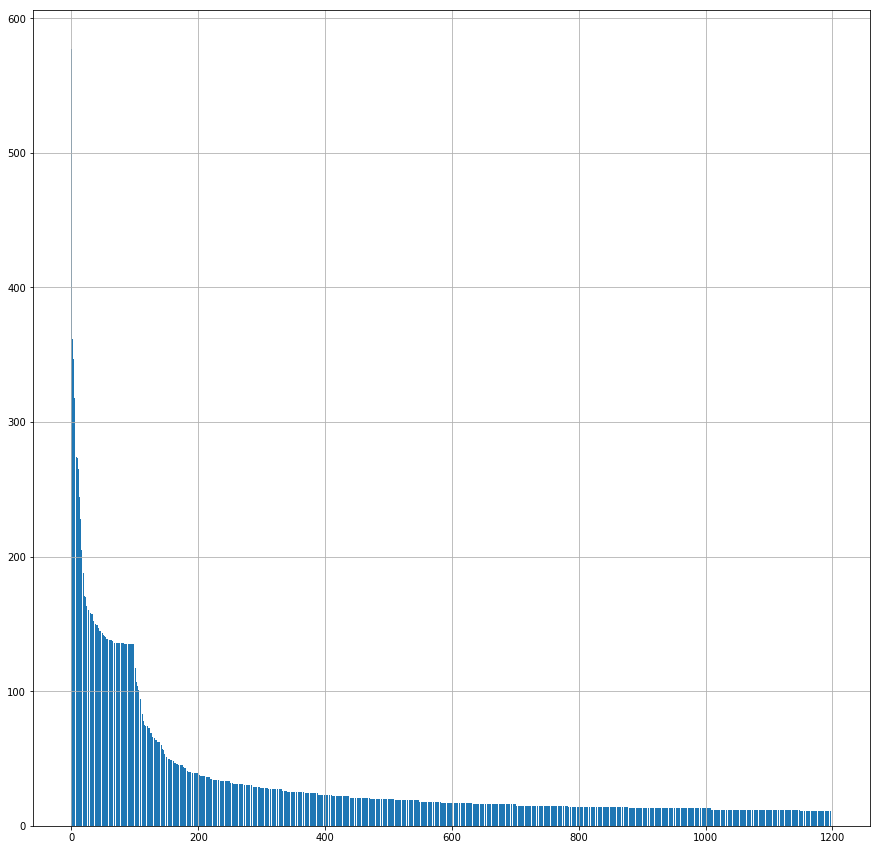

In [317]:
plot_data = [i[1] for i in sorted(cor_list, key=lambda x:x[1], reverse=True)][:1200]
plt.figure(figsize=(15, 15))
plt.bar(np.arange(len(plot_data)), plot_data)
plt.grid()
plt.show()

In [315]:
# stop_words = ["failed", "cant", "not", "to", "could", "cannot", "is", "a", "for", "fail"]
stop_words = ["for", "type", "set", "fail", "is", "cant", "not", "error", "to", "the", "length", "arc", "on", "#i", "bound", "default", "#f", "bind", "be", "of", "a", "in"]

In [329]:
# G = nx.DiGraph()
G = nx.Graph()
nx.set_node_attributes

for i in sorted(cor_list, key=lambda x:x[1], reverse=True):
    if i[1] > 5: # 共起がn回以上
        a,b = i[0]
        
        if vy_id2word[a] in stop_words or vy_id2word[b] in stop_words:
            continue
            
        simpson = i[1]/min(word_cnt[vy_id2word[a]], word_cnt[vy_id2word[b]])
        jaccard = i[1]/(word_cnt[vy_id2word[a]] + word_cnt[vy_id2word[b]] - i[1])
        if simpson > 1.0 :
            simpson = 1.0
        if jaccard < 0. :
            jaccard = 1e-5
        
        if a == vy_word2id['zebra'] or b == vy_word2id['zebra']:
            print(simpson, jaccard, vy_id2word[a], vy_id2word[b], word_cnt[vy_id2word[a]], word_cnt[vy_id2word[b]], i)
        if simpson > 0.9:
            if a not in G.nodes:
                G.add_node(vy_id2word[a])

            if b not in G.nodes:
                G.add_node(vy_id2word[b])

            src = vy_id2word[a] if np.argmin([word_cnt[vy_id2word[a]], word_cnt[vy_id2word[b]]]) == 0 else vy_id2word[b]
            dst = vy_id2word[a] if src == vy_id2word[b] else vy_id2word[b]
            G.add_edge(src, dst) # weight=jaccard)

0.4492753623188406 0.10367892976588629 interface zebra 261 69 [(643, 1220), 31]
0.38 0.19 delete zebra 50 69 [(41, 1220), 19]
0.2753623188405797 0.06418918918918919 route zebra 246 69 [(669, 1220), 19]
0.2608695652173913 0.11612903225806452 add zebra 104 69 [(690, 1220), 18]
0.2028985507246377 0.05907172995780591 receive zebra 182 69 [(1189, 1220), 14]
0.29545454545454547 0.13 metric zebra 44 69 [(144, 1220), 13]
0.2033898305084746 0.10344827586206896 nexthop zebra 59 69 [(852, 1220), 12]
0.14492753623188406 0.0625 index zebra 101 69 [(982, 1220), 10]
0.13043478260869565 0.04054054054054054 address zebra 162 69 [(1044, 1220), 9]
0.21621621621621623 0.08163265306122448 mtu zebra 37 69 [(358, 1220), 8]
0.11594202898550725 0.03864734299516908 send zebra 146 69 [(750, 1220), 8]
0.11594202898550725 0.04060913705583756 message zebra 136 69 [(1082, 1220), 8]
0.08695652173913043 0.045112781954887216 ipv6 zebra 70 69 [(312, 1220), 6]
0.08695652173913043 0.01011804384485666 can zebra 530 69 [(72

In [330]:
json_data = nx.node_link_data(G)
f = open("./d3/vyos_nx_normal_cnt.json", "w")
json.dump(json_data, f, ensure_ascii=False, indent=4, sort_keys=True, separators=(',', ': '))
f.close()

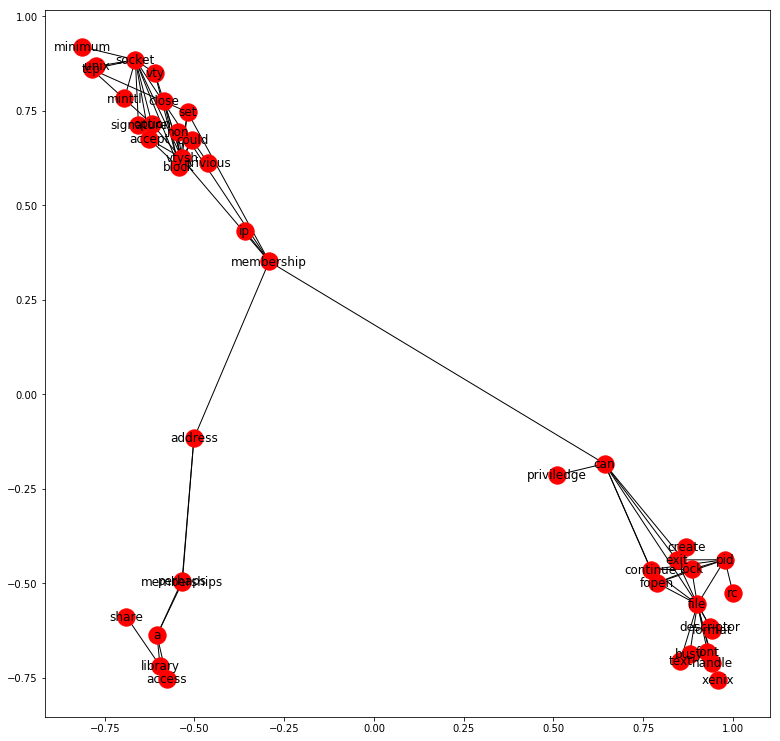

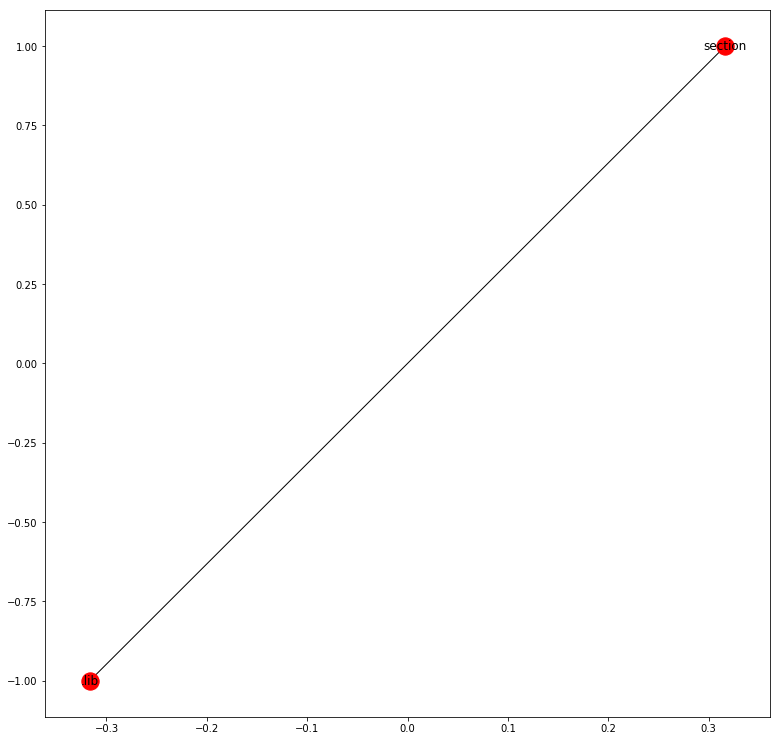

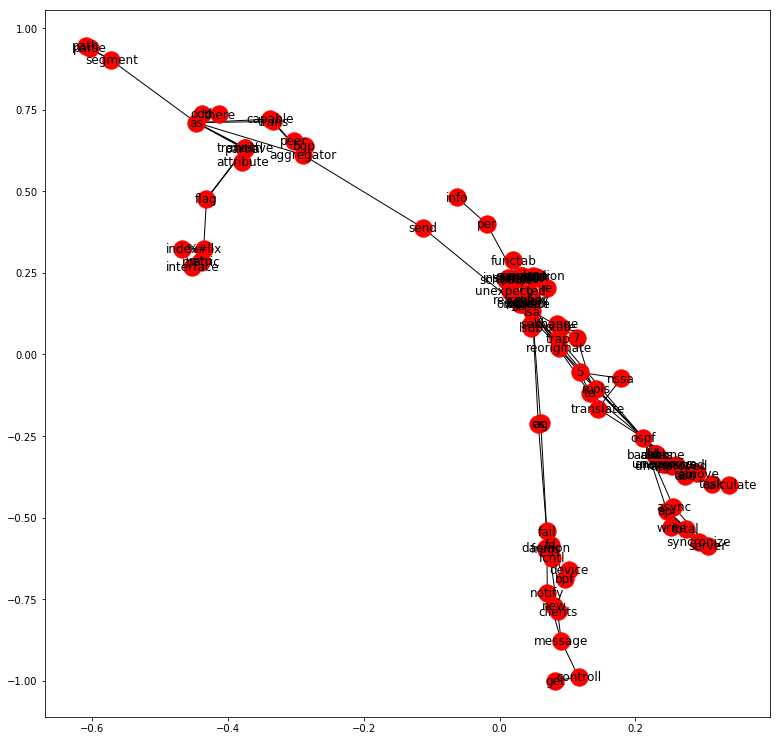

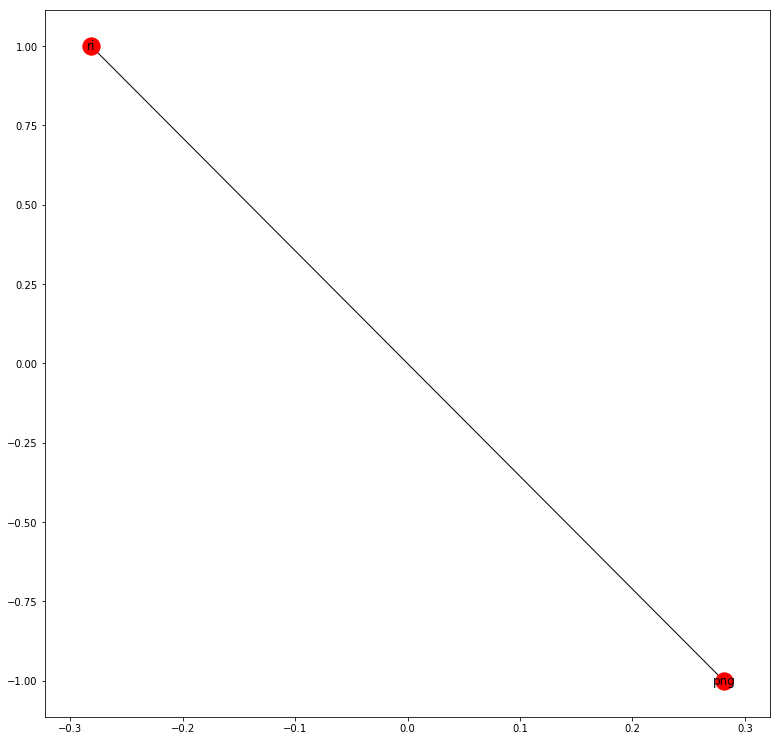

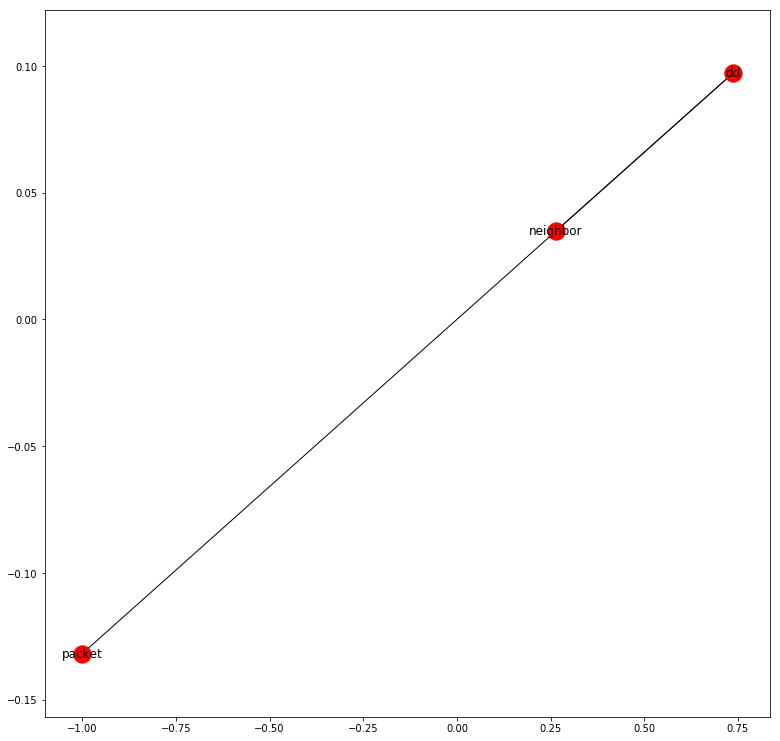

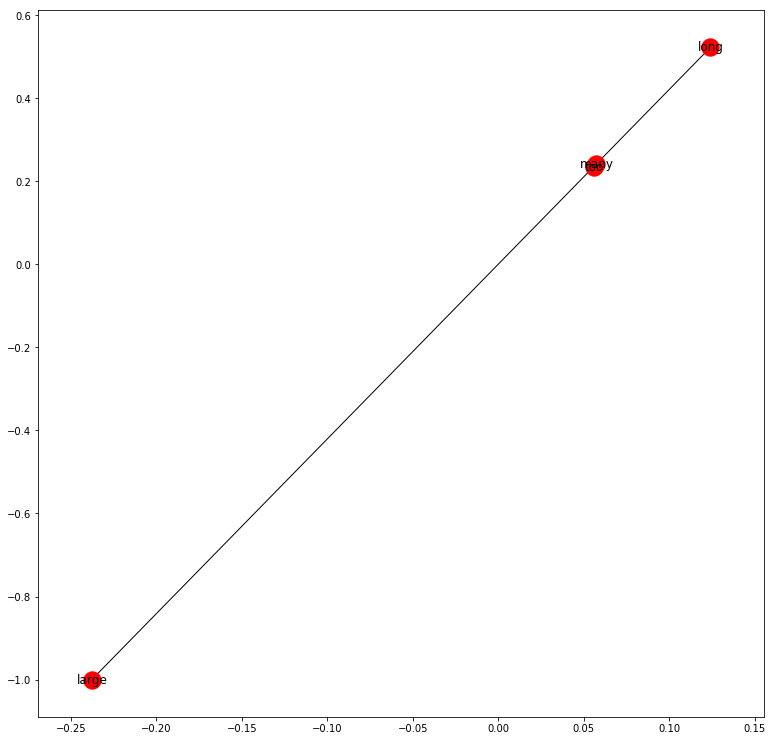

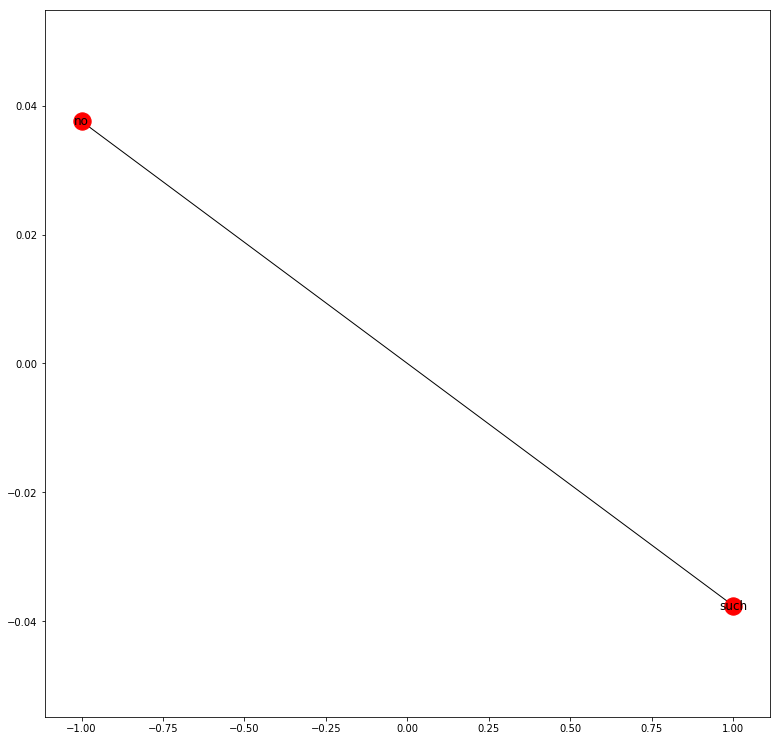

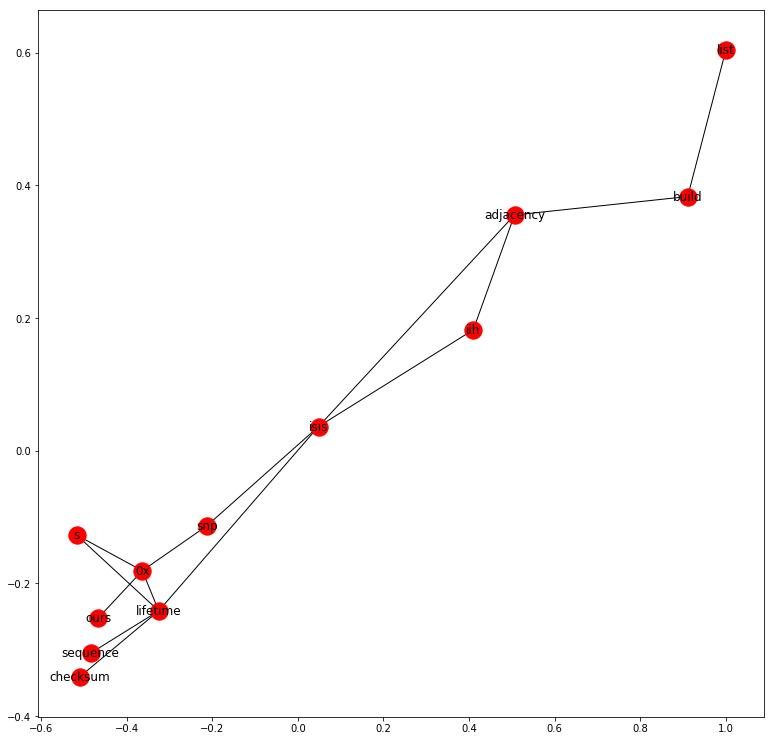

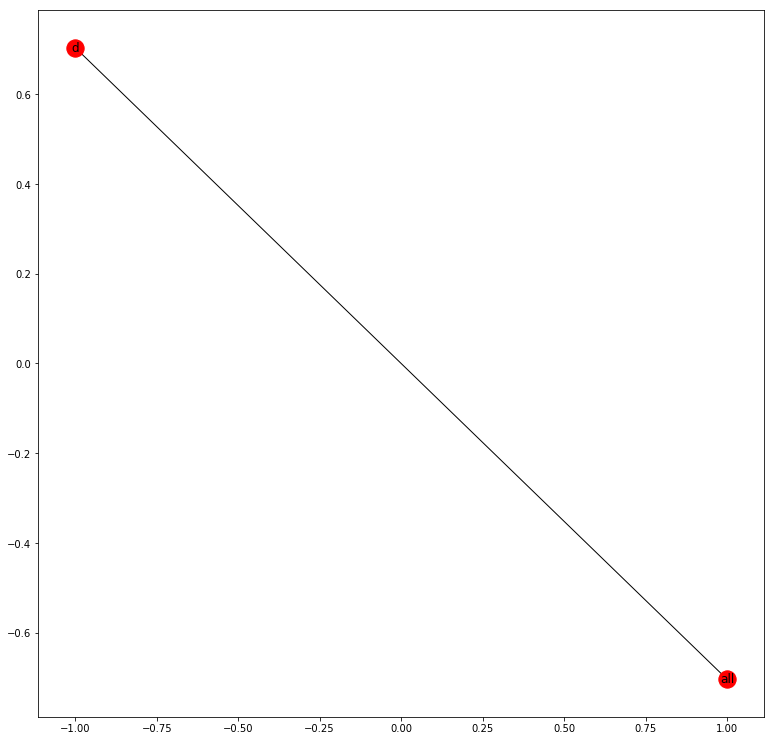

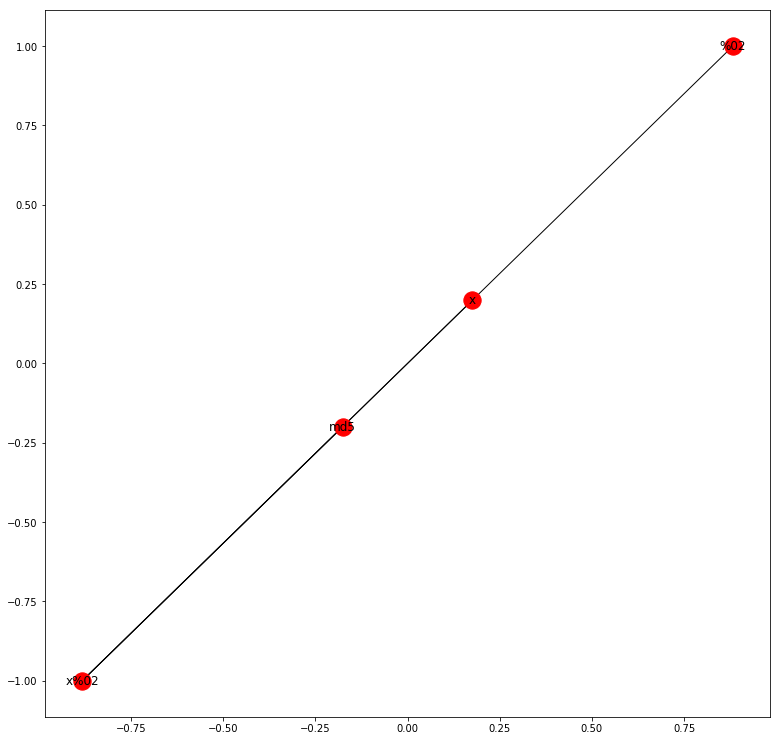

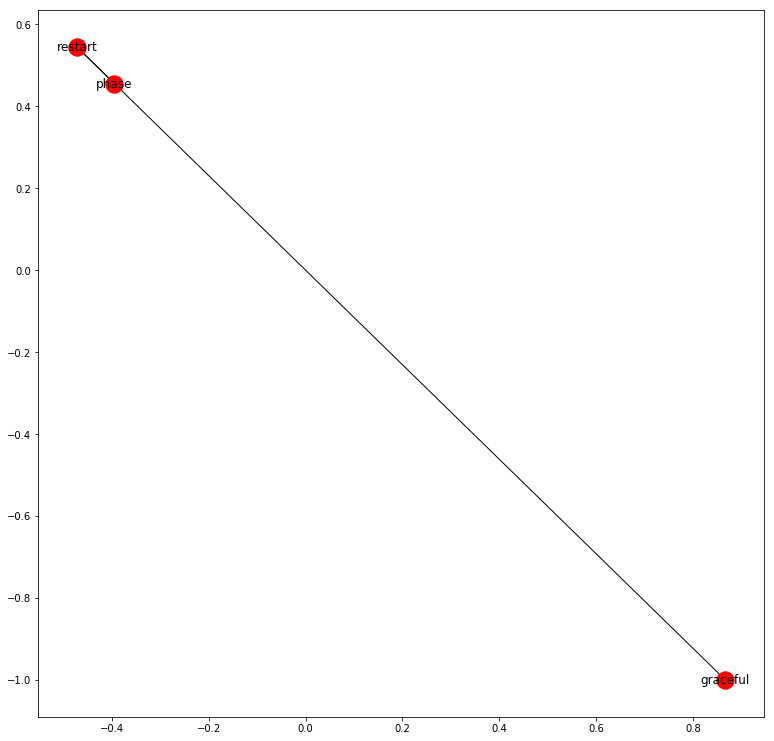

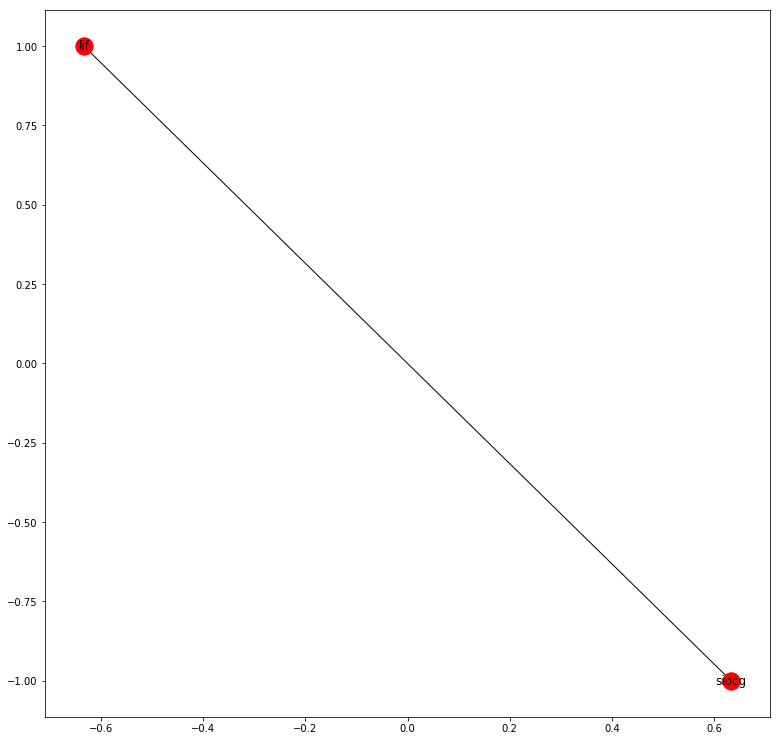

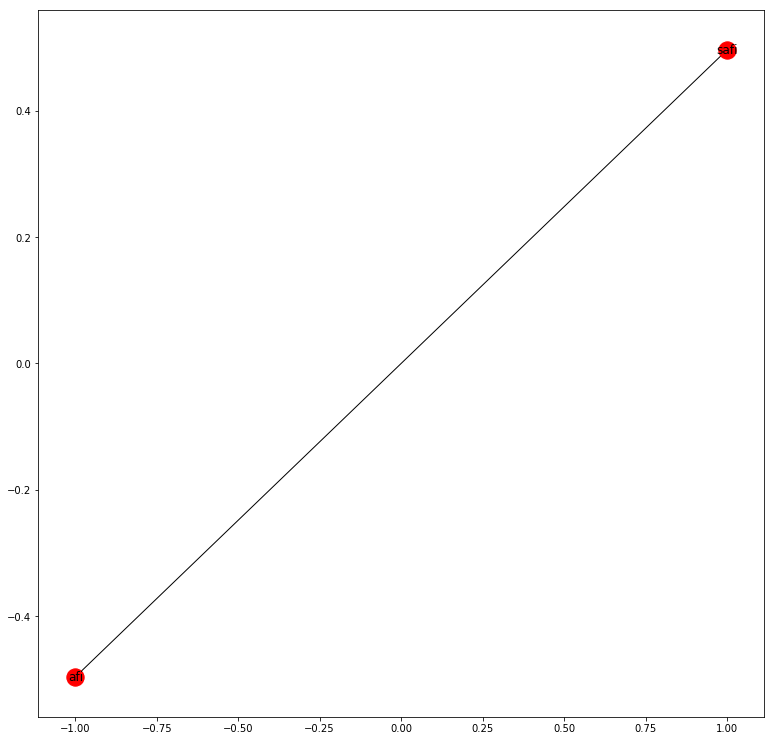

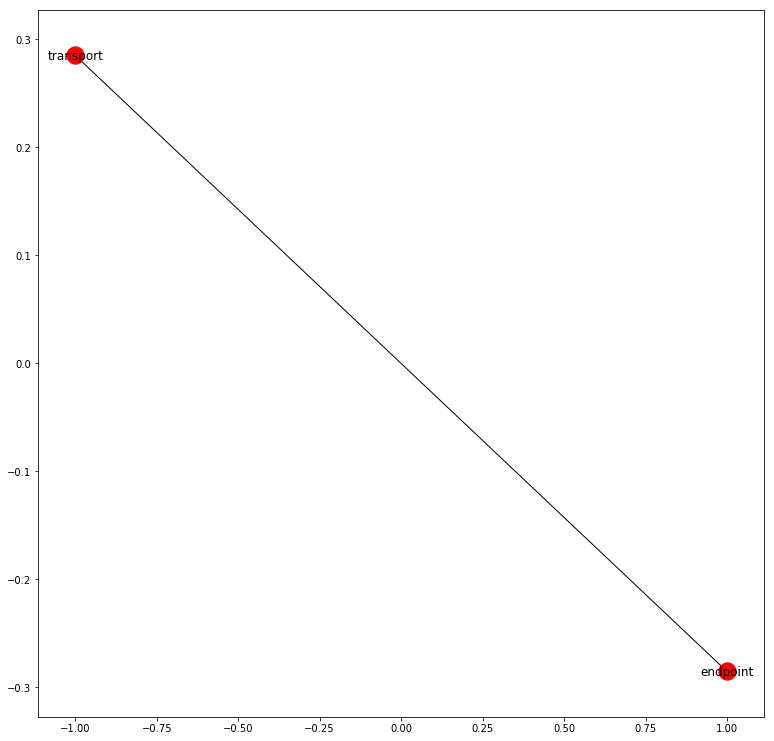

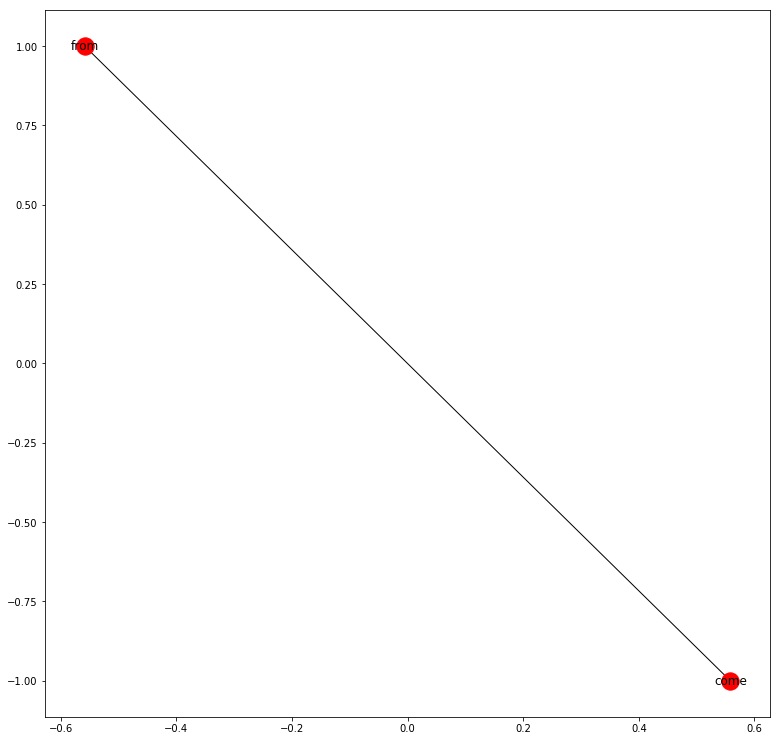

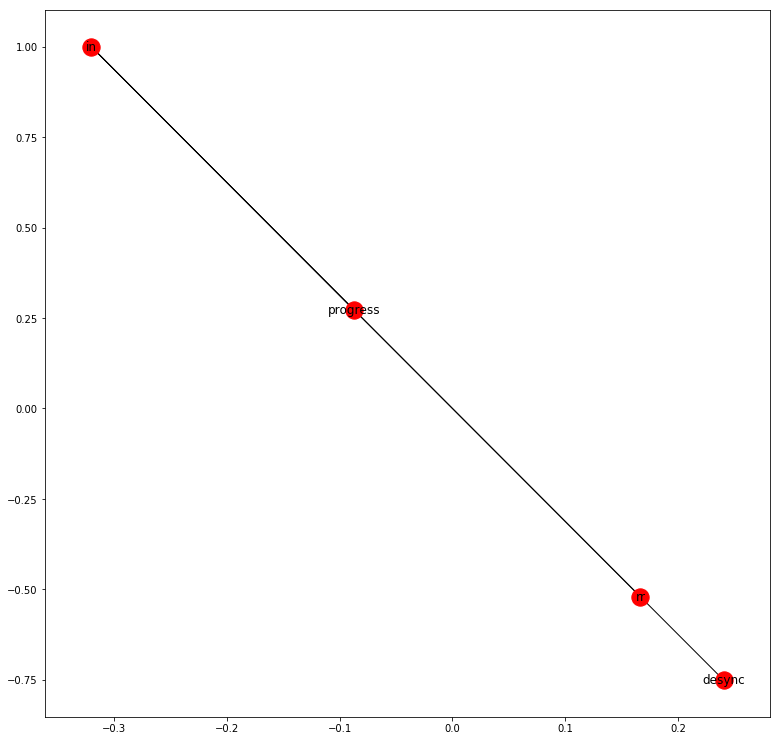

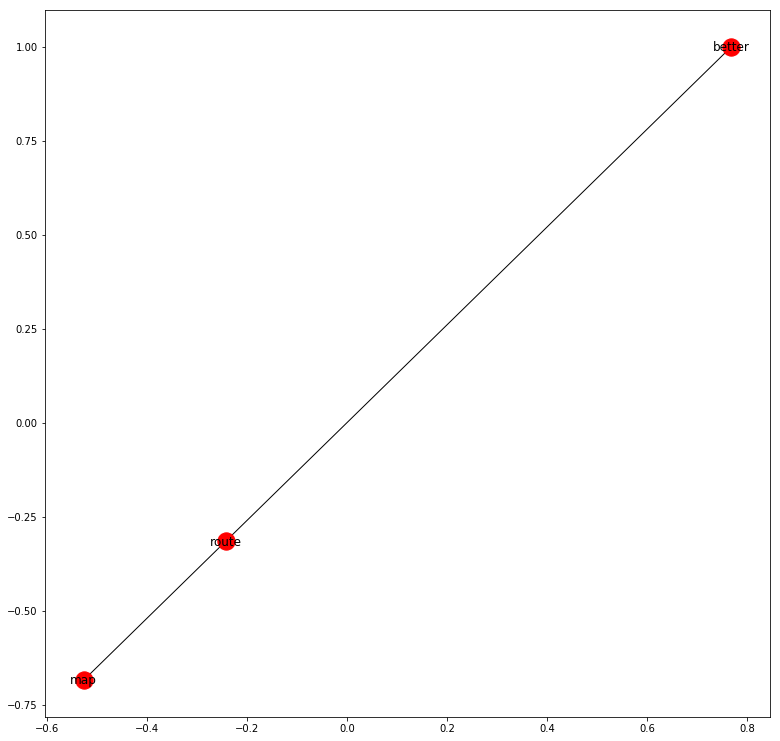

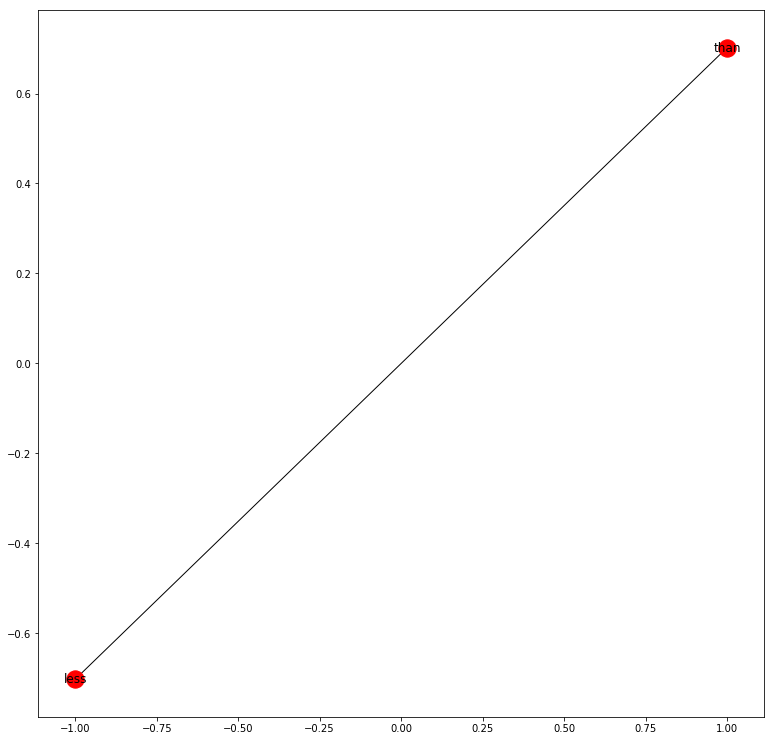

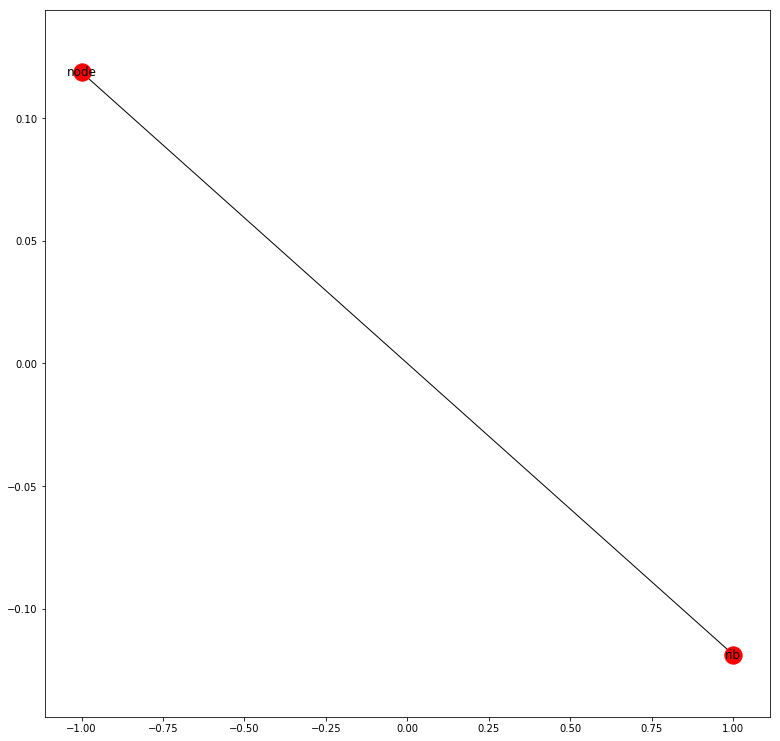

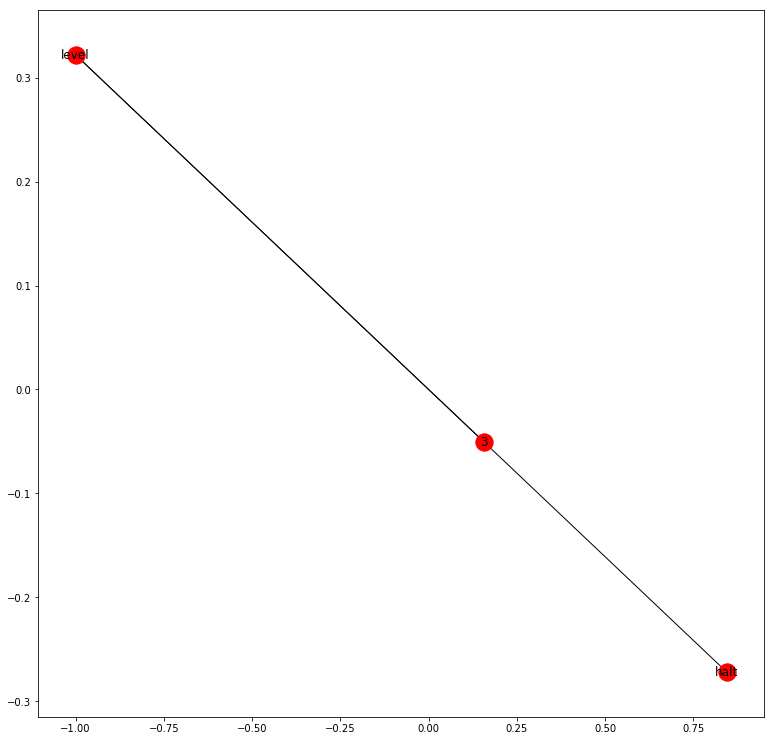

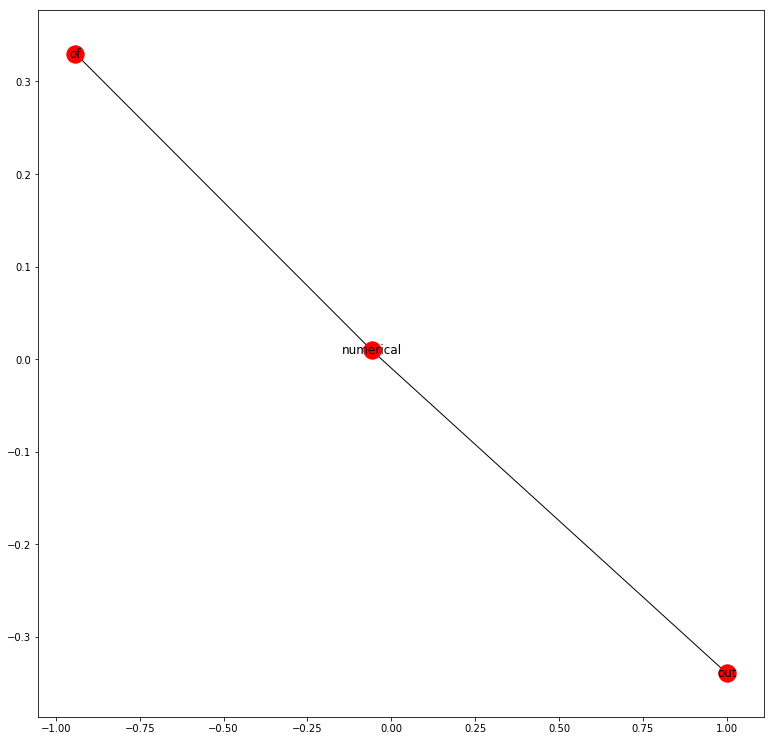

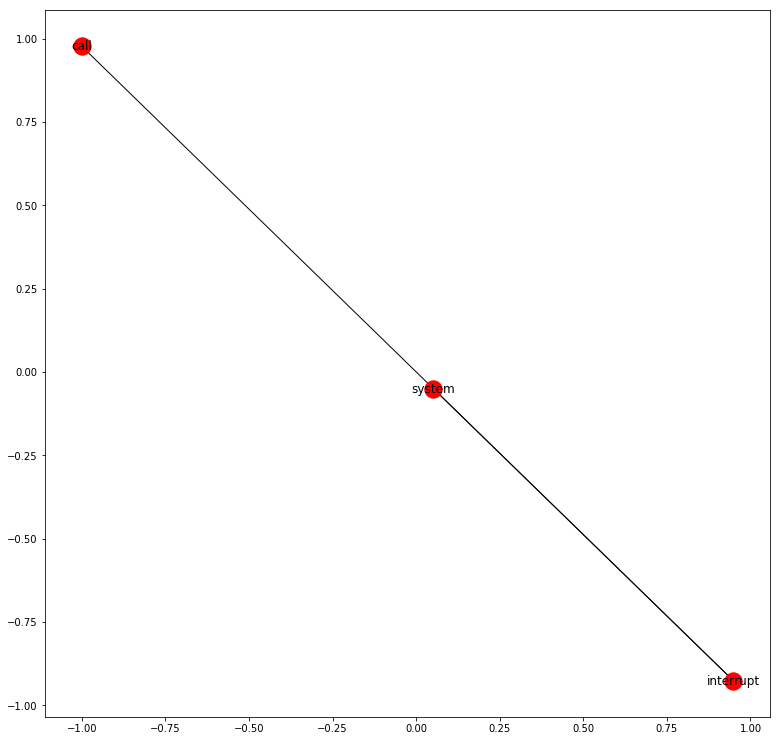

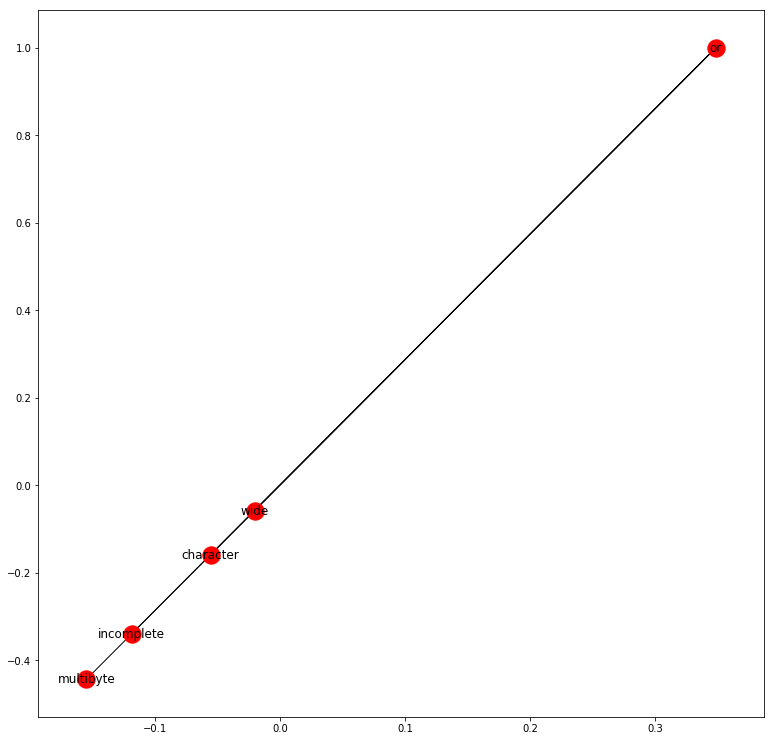

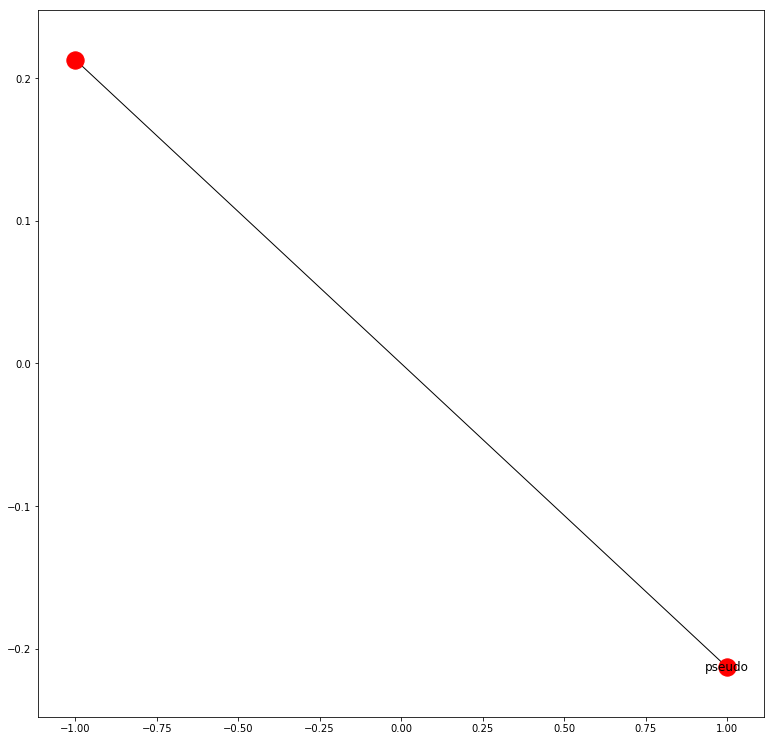

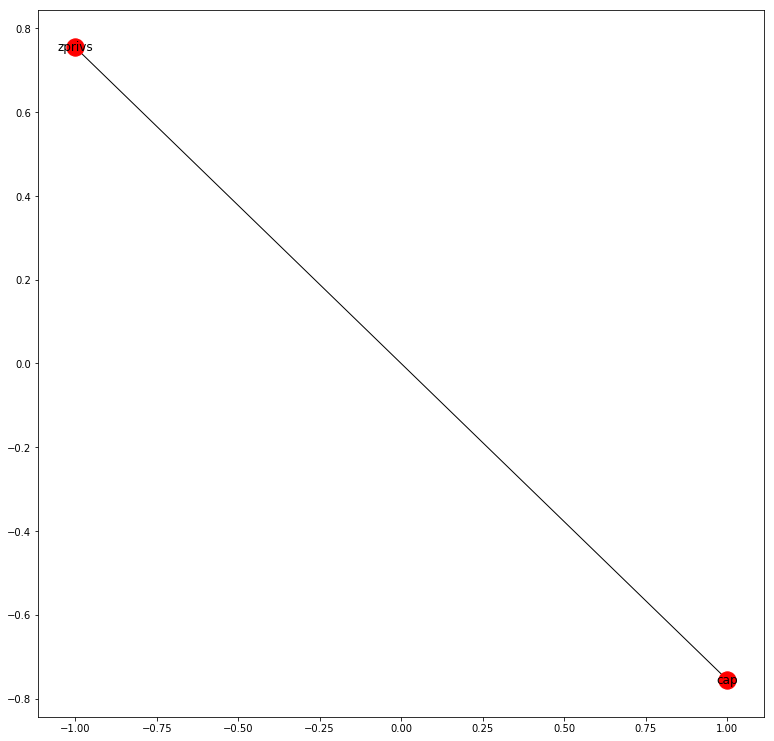

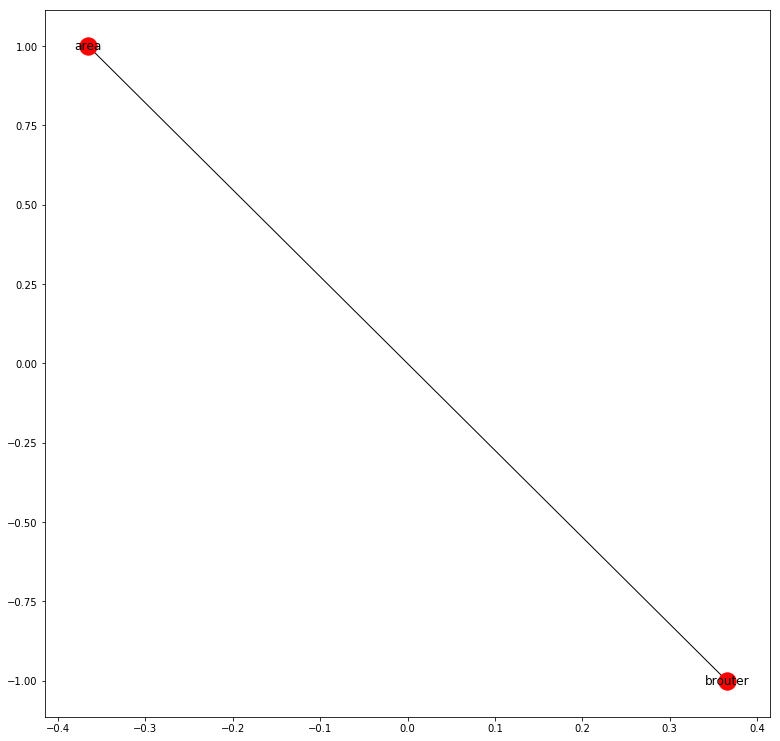

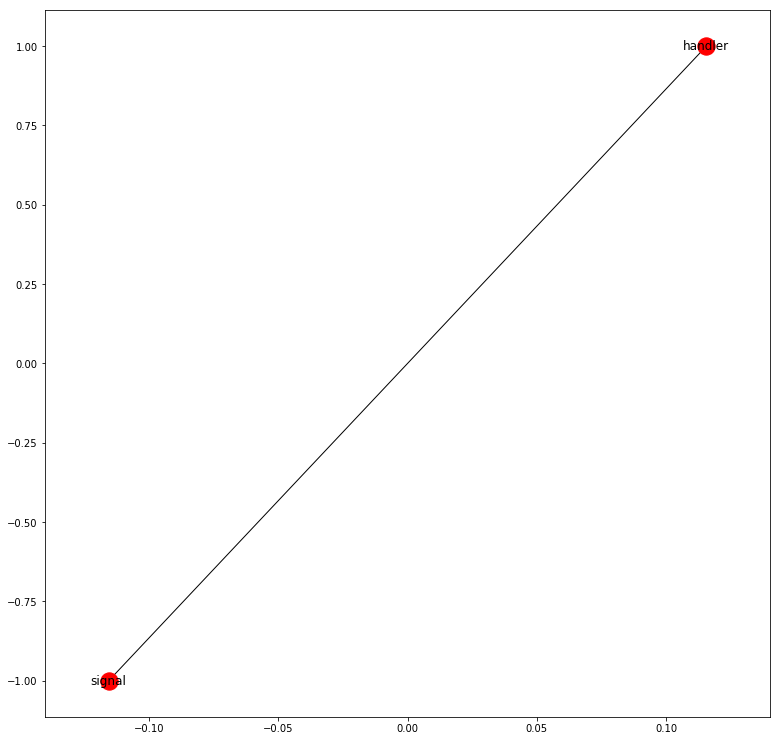

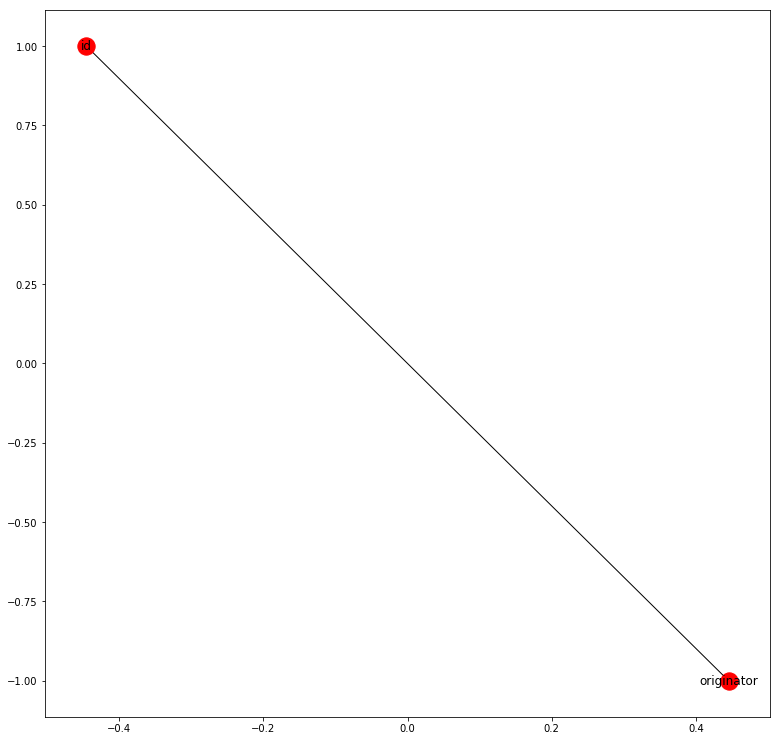

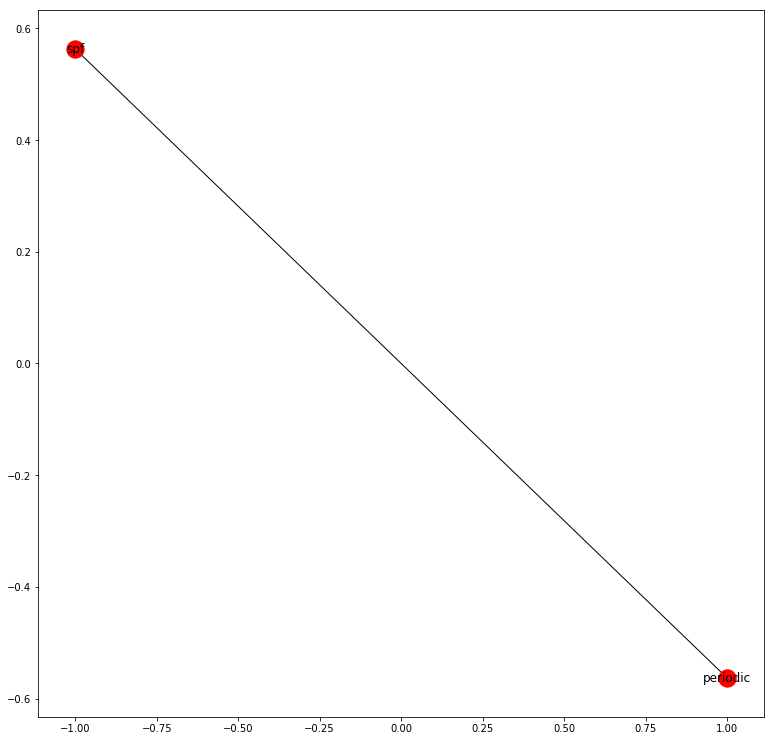

In [161]:
for i, nodes in enumerate(list(nx.connected_components(G))):
    H = G.copy()
    H.remove_nodes_from(G.nodes - nodes)
    plt.figure(figsize=(13, 13))
    pos = nx.spring_layout(H, k=0.001)
    nx.draw_networkx(H, pos=pos)
    plt.show()
    
    json_data = nx.node_link_data(H)
    f = open("./d3/vyos_nx_{}.json".format(i), "w")
    json.dump(json_data, f, ensure_ascii=False, indent=4, sort_keys=True, separators=(',', ': '))
    f.close()

In [ ]:
pos = nx.spring_layout(G, k=0.0001)

plt.figure(figsize=(13, 13))
nx.draw_networkx(G, pos=pos)
plt.show()

In [ ]:
vy_word2id

In [320]:
## remove stop words for LDA

tmp = []
vyos_eval_corpus = []
vyos_eval_corpus_ltids = []

for ltid, i in enumerate(corpus):
#     if word2id['ui'] not in [j[0] for j in i]: # uiを弾く
    i = [j for j in i if vy_id2word[j[0]] not in stop_words]
    tmp.append(tuple(sorted(i)))
    vyos_eval_corpus.append(i)
    vyos_eval_corpus_ltids.append(ltid)
    
vyos_set_corpus = list(set(tmp))

In [321]:
vyos_lda = gensim.models.ldamodel.LdaModel(
#                                       corpus=corpus,
                                      corpus=vyos_set_corpus,
                                      chunksize=5,
                                      num_topics=10, 
                                      id2word=vy_id2word, 
                                      minimum_probability=1e-8, 
                                      #gamma_threshold=1e-5,
                                      #eval_every=10,
                                      iterations=100,
#                                       alpha='auto', 
#                                       eta='auto', 
                                      decay=1.0,
                                      passes=1,
                                      per_word_topics=True)

In [322]:
results =  [np.argmax(l) for l in vyos_lda.inference(corpus)[0]]

# inference_results = {}
# for a,b in zip(eval_corpus, results):
#     if b in inference_results:
#         inference_results[b].append([id2word[c[0]] for c in a])
#     else:
#         inference_results[b] = [[id2word[c[0]] for c in a]]

In [323]:
inf_topic_words = {}
for topic in range(vyos_lda.num_topics):
    print(topic, [vy_id2word[i[0]] for i in vyos_lda.get_topic_terms(topic)])
    inf_topic_words[topic] = [vy_id2word[i[0]] for i in vyos_lda.get_topic_terms(topic)]

0 ['can', 'file', 'lock', 'create', 'exit', 'unknown', 'smux', 'out', 'peer', 'ipv6']
1 ['pid', 'sequence', 'block', 'device', 'invalid', 'protocol', 'available', 'or', 'level', 'support']
2 ['ospf', 'abr', 'new', 'process', '0x', 'ri', 'api', 'nssa', 'start', 'server']
3 ['socket', 'could', 'address', 'access', 'option', 'fd', 'ip', 'originate', 'bgp', 'ipv6']
4 ['accept', 'close', 'vty', 'non', 'vtysh', 'flag', 'prefix', 'attribute', 'connect', 'restart']
5 ['route', 'receive', 'packet', 'neighbor', 'link', 'state', 'from', 'ignore', 'external', 'send']
6 ['interface', 'network', 'continue', 'fopen', 'add', 'index', 'zebra', 'too', 'spf', 'change']
7 ['no', 'isis', 'find', 'nexthop', 'by', 'list', 'connection', 'circuit', 'from', 'remove']
8 ['lsa', 'as', 'opaque', 'area', 'get', 'router', 'id', 'open', 'update', 'refresh']
9 ['.lib', 'section', 'message', 'send', 'read', 'cannot', 'size', 'write', 'buffer', 'path']


In [309]:
def vyos_string_to_corpus(lt, max_len=None, use_spdict=False):
    
    lt = lt.replace('w/', 'with').replace('IPv4', 'ipv4').replace('IPv6', 'ipv6')
    
    words = [remove_symbols(t).strip() for t in lt.strip().split()]
    words = [w for w in words if len(w) != 0]
    
    split_words = []
    for w in words:
        if len(w.split()) > 1: # さらに分割できる場合
            split_words.extend(w.split())
        else:
            split_words.append(w)
            
    split_words = [remove_last_symbol(t) for t in split_words if t != '']
    split_words = [t.lower().strip() for t in split_words if t != '']
    split_words = [WordNetLemmatizer().lemmatize(t, 'v') for t in split_words]

    ## validate NNS or specific word
    ## e.g., avoiding "junos" -> "juno" 
    tmp = []
    for t in split_words:
        if nltk.pos_tag(t)[0][1] == "NNS" and (t not in lemmataize_blacklist):
            t = WordNetLemmatizer().lemmatize(t, 'n')
        tmp.append(t)
    split_words = tmp

    if use_spdict:
        ## use specific word dict
        ## e.g., "cmd" -> "command"
        tmp = []
        for t in split_words:
            if t in vyos_specific_word_dict:
                converted_word = vyos_specific_word_dict[t]
                if type(converted_word) == list:
                    tmp.extend(converted_word)
                else:
                    tmp.append(converted_word)
            else:
                tmp.append(t)
        split_words = tmp
        split_words = [w.strip() for w in split_words]

        split_words = remove_error_words(split_words)
        split_words = [w.strip() for w in split_words if len(w.strip()) != 0]
        tmp_corpus.append(split_words)
        
    if max_len != None:
        split_words = split_words[:max_len] # 前方のみ残す

    return split_words

In [324]:
## show results

lt_per_infclass = {}
for i in range(vyos_lda.num_topics):
    lt_per_infclass[i] = []

for lt in tqdm.tqdm(raw_vyos):
    c = list(collections.Counter([vy_word2id[w] for w in vyos_string_to_corpus(lt, max_len=None, use_spdict=True)]).items())
    topic_dist, word_topic, word_topic_dist = vyos_lda[c]
    inf_topic = np.argmax(np.array([t[1] for t in topic_dist]))
    lt_per_infclass[inf_topic].append(lt)

100%|██████████| 29264/29264 [02:01<00:00, 241.32it/s]


In [311]:
for k,v in lt_per_infclass.items():
    print(k)
    for vv in v:
        print("\t", vv.strip())
    print()

0
	 
	 **
	 #**: **
	 **
	 ** **
	 ** ** process ** exited normally
	 ** ** process ** exited with non-zero status **
	 ** [FSM] Trying to start suppressed peer - this is never supposed to happen!
	 ** open active, local address **
	 ** socket isn't active.
	 **:
	 **: **
	 **: ** ** ** **
	 **: Out of space in LSA stream, left %zd, size %zd
	 **:**
	 **<-[**]->** : **
	 -
	 -----------------------------------------------------
	 -> **
	 ?
	 AN ISH PDU!!
	 Area[**]: Configured as **
	 Can't read all SMUX packet: **
	 Cannot locate loopback service smux
	 Check for NSSA-ABR Tasks():
	 Flood/AS: NSSA TRANSLATED LSA
	 Incoming External LSA Discarded: We are NSSA/STUB Area
	 Incoming NSSA LSA Discarded:  Not NSSA Area
	 NSSA
	 Not an IS-IS or ES-IS packet IDRP=**
	 R **\t**\t**\t**
	 RXmtL(**)++, NBR(**), LSA[**]
	 RXmtL(**)--, NBR(**), LSA[**]
	 Redistribute[**]: Stop
	 Redistribute[DEFAULT]: Stop
	 Running ABR task on timer
	 SMUX GET errindex ** len: %zd
	 SMUX GET errstat ** len: %zd
	

	 can't setsockopt IP_DROP_MEMBERSHIP (fd **, addr **, ifindex **, AllSPFRouters): Owner died
	 can't setsockopt IP_DROP_MEMBERSHIP (fd **, addr **, ifindex **, AllSPFRouters): Package not installed
	 can't setsockopt IP_DROP_MEMBERSHIP (fd **, addr **, ifindex **, AllSPFRouters): Permission denied
	 can't setsockopt IP_DROP_MEMBERSHIP (fd **, addr **, ifindex **, AllSPFRouters): Protocol driver not attached
	 can't setsockopt IP_DROP_MEMBERSHIP (fd **, addr **, ifindex **, AllSPFRouters): Protocol error
	 can't setsockopt IP_DROP_MEMBERSHIP (fd **, addr **, ifindex **, AllSPFRouters): Protocol family not supported
	 can't setsockopt IP_DROP_MEMBERSHIP (fd **, addr **, ifindex **, AllSPFRouters): Protocol not available
	 can't setsockopt IP_DROP_MEMBERSHIP (fd **, addr **, ifindex **, AllSPFRouters): Protocol not supported
	 can't setsockopt IP_DROP_MEMBERSHIP (fd **, addr **, ifindex **, AllSPFRouters): Protocol wrong type for socket
	 can't setsockopt IP_DROP_MEMBERSHIP (fd **, addr 

	 waitpid failed: Device not a stream
	 waitpid failed: Device or resource busy
	 waitpid failed: Disk quota exceeded
	 waitpid failed: Exchange full
	 waitpid failed: Exec format error
	 waitpid failed: File descriptor in bad state
	 waitpid failed: File exists
	 waitpid failed: File name too long
	 waitpid failed: File too large
	 waitpid failed: Function not implemented
	 waitpid failed: Host is down
	 waitpid failed: Identifier removed
	 waitpid failed: Illegal seek
	 waitpid failed: Inappropriate ioctl for device
	 waitpid failed: Input/output error
	 waitpid failed: Interrupted system call
	 waitpid failed: Interrupted system call should be restarted
	 waitpid failed: Invalid argument
	 waitpid failed: Invalid cross-device link
	 waitpid failed: Invalid exchange
	 waitpid failed: Invalid or incomplete multibyte or wide character
	 waitpid failed: Invalid request code
	 waitpid failed: Invalid slot
	 waitpid failed: Is a directory
	 waitpid failed: Is a named type file
	 waitpid f

	 SMUX register message send failed: Link has been severed
	 SMUX register message send failed: Link number out of range
	 SMUX register message send failed: Machine is not on the network
	 SMUX register message send failed: Memory page has hardware error
	 SMUX register message send failed: Message too long
	 SMUX register message send failed: Multihop attempted
	 SMUX register message send failed: Name not unique on network
	 SMUX register message send failed: Network dropped connection on reset
	 SMUX register message send failed: Network is down
	 SMUX register message send failed: Network is unreachable
	 SMUX register message send failed: No CSI structure available
	 SMUX register message send failed: No XENIX semaphores available
	 SMUX register message send failed: No anode
	 SMUX register message send failed: No buffer space available
	 SMUX register message send failed: No child processes
	 SMUX register message send failed: No data available
	 SMUX register message send fail

	 Can't set IP_RECVIF option for fd ** to **: Operation now in progress
	 Can't set IP_RECVIF option for fd ** to **: Out of streams resources
	 Can't set IP_RECVIF option for fd ** to **: Owner died
	 Can't set IP_RECVIF option for fd ** to **: Package not installed
	 Can't set IP_RECVIF option for fd ** to **: Permission denied
	 Can't set IP_RECVIF option for fd ** to **: Protocol driver not attached
	 Can't set IP_RECVIF option for fd ** to **: Protocol error
	 Can't set IP_RECVIF option for fd ** to **: Protocol family not supported
	 Can't set IP_RECVIF option for fd ** to **: Protocol not available
	 Can't set IP_RECVIF option for fd ** to **: Protocol not supported
	 Can't set IP_RECVIF option for fd ** to **: Protocol wrong type for socket
	 Can't set IP_RECVIF option for fd ** to **: RFS specific error
	 Can't set IP_RECVIF option for fd ** to **: Read-only file system
	 Can't set IP_RECVIF option for fd ** to **: Remote I/O error
	 Can't set IP_RECVIF option for fd ** to **:

	 **: Can't bind socket ** to ** port **: Host is down
	 **: Can't bind socket ** to ** port **: Identifier removed
	 **: Can't bind socket ** to ** port **: Illegal seek
	 **: Can't bind socket ** to ** port **: Inappropriate ioctl for device
	 **: Can't bind socket ** to ** port **: Input/output error
	 **: Can't bind socket ** to ** port **: Interrupted system call
	 **: Can't bind socket ** to ** port **: Interrupted system call should be restarted
	 **: Can't bind socket ** to ** port **: Invalid argument
	 **: Can't bind socket ** to ** port **: Invalid cross-device link
	 **: Can't bind socket ** to ** port **: Invalid exchange
	 **: Can't bind socket ** to ** port **: Invalid or incomplete multibyte or wide character
	 **: Can't bind socket ** to ** port **: Invalid request code
	 **: Can't bind socket ** to ** port **: Invalid request descriptor
	 **: Can't bind socket ** to ** port **: Invalid slot
	 **: Can't bind socket ** to ** port **: Is a directory
	 **: Can't bind sock

	 can't setsockopt IP_ADD_MEMBERSHIP Srmount error
	 can't setsockopt IP_ADD_MEMBERSHIP Stale file handle
	 can't setsockopt IP_ADD_MEMBERSHIP State not recoverable
	 can't setsockopt IP_ADD_MEMBERSHIP Streams pipe error
	 can't setsockopt IP_ADD_MEMBERSHIP Structure needs cleaning
	 can't setsockopt IP_ADD_MEMBERSHIP Success
	 can't setsockopt IP_ADD_MEMBERSHIP Text file busy
	 can't setsockopt IP_ADD_MEMBERSHIP Timer expired
	 can't setsockopt IP_ADD_MEMBERSHIP Too many levels of symbolic links
	 can't setsockopt IP_ADD_MEMBERSHIP Too many links
	 can't setsockopt IP_ADD_MEMBERSHIP Too many open files
	 can't setsockopt IP_ADD_MEMBERSHIP Too many open files in system
	 can't setsockopt IP_ADD_MEMBERSHIP Too many references: cannot splice
	 can't setsockopt IP_ADD_MEMBERSHIP Too many users
	 can't setsockopt IP_ADD_MEMBERSHIP Transport endpoint is already connected
	 can't setsockopt IP_ADD_MEMBERSHIP Transport endpoint is not connected
	 can't setsockopt IP_ADD_MEMBERSHIP Unknown err

	 Can't get local address and port by getsockname: No locks available
	 Can't get local address and port by getsockname: No medium found
	 Can't get local address and port by getsockname: No message of desired type
	 Can't get local address and port by getsockname: No route to host
	 Can't get local address and port by getsockname: No space left on device
	 Can't get local address and port by getsockname: No such device
	 Can't get local address and port by getsockname: No such device or address
	 Can't get local address and port by getsockname: No such file or directory
	 Can't get local address and port by getsockname: No such process
	 Can't get local address and port by getsockname: Not a XENIX named type file
	 Can't get local address and port by getsockname: Not a directory
	 Can't get local address and port by getsockname: Numerical argument out of domain
	 Can't get local address and port by getsockname: Numerical result out of range
	 Can't get local address and port by getsoc

	 **: access to socket ** denied: Operation canceled
	 **: access to socket ** denied: Operation not permitted
	 **: access to socket ** denied: Operation not possible due to RF-kill
	 **: access to socket ** denied: Operation not supported
	 **: access to socket ** denied: Operation now in progress
	 **: access to socket ** denied: Out of streams resources
	 **: access to socket ** denied: Owner died
	 **: access to socket ** denied: Package not installed
	 **: access to socket ** denied: Permission denied
	 **: access to socket ** denied: Protocol driver not attached
	 **: access to socket ** denied: Protocol error
	 **: access to socket ** denied: Protocol family not supported
	 **: access to socket ** denied: Protocol not available
	 **: access to socket ** denied: Protocol not supported
	 **: access to socket ** denied: Protocol wrong type for socket
	 **: access to socket ** denied: RFS specific error
	 **: access to socket ** denied: Read-only file system
	 **: access to socket 

	 SIOCGLIFSUBNET (**) fail: No space left on device
	 SIOCGLIFSUBNET (**) fail: No such device
	 SIOCGLIFSUBNET (**) fail: No such device or address
	 SIOCGLIFSUBNET (**) fail: No such file or directory
	 SIOCGLIFSUBNET (**) fail: No such process
	 SIOCGLIFSUBNET (**) fail: Not a XENIX named type file
	 SIOCGLIFSUBNET (**) fail: Not a directory
	 SIOCGLIFSUBNET (**) fail: Numerical argument out of domain
	 SIOCGLIFSUBNET (**) fail: Numerical result out of range
	 SIOCGLIFSUBNET (**) fail: Object is remote
	 SIOCGLIFSUBNET (**) fail: Operation already in progress
	 SIOCGLIFSUBNET (**) fail: Operation canceled
	 SIOCGLIFSUBNET (**) fail: Operation not permitted
	 SIOCGLIFSUBNET (**) fail: Operation not possible due to RF-kill
	 SIOCGLIFSUBNET (**) fail: Operation not supported
	 SIOCGLIFSUBNET (**) fail: Operation now in progress
	 SIOCGLIFSUBNET (**) fail: Out of streams resources
	 SIOCGLIFSUBNET (**) fail: Owner died
	 SIOCGLIFSUBNET (**) fail: Package not installed
	 SIOCGLIFSUBNET (

	 isis_recv_pdu_p2p(): read () failed: Operation not permitted
	 isis_recv_pdu_p2p(): read () failed: Operation not possible due to RF-kill
	 isis_recv_pdu_p2p(): read () failed: Operation not supported
	 isis_recv_pdu_p2p(): read () failed: Operation now in progress
	 isis_recv_pdu_p2p(): read () failed: Out of streams resources
	 isis_recv_pdu_p2p(): read () failed: Owner died
	 isis_recv_pdu_p2p(): read () failed: Package not installed
	 isis_recv_pdu_p2p(): read () failed: Permission denied
	 isis_recv_pdu_p2p(): read () failed: Protocol driver not attached
	 isis_recv_pdu_p2p(): read () failed: Protocol error
	 isis_recv_pdu_p2p(): read () failed: Protocol family not supported
	 isis_recv_pdu_p2p(): read () failed: Protocol not available
	 isis_recv_pdu_p2p(): read () failed: Protocol not supported
	 isis_recv_pdu_p2p(): read () failed: Protocol wrong type for socket
	 isis_recv_pdu_p2p(): read () failed: RFS specific error
	 isis_recv_pdu_p2p(): read () failed: Read-only file sys

	 Cannot create UDP socket: Name not unique on network
	 Cannot create UDP socket: Network dropped connection on reset
	 Cannot create UDP socket: Network is down
	 Cannot create UDP socket: Network is unreachable
	 Cannot create UDP socket: No CSI structure available
	 Cannot create UDP socket: No XENIX semaphores available
	 Cannot create UDP socket: No anode
	 Cannot create UDP socket: No buffer space available
	 Cannot create UDP socket: No child processes
	 Cannot create UDP socket: No data available
	 Cannot create UDP socket: No locks available
	 Cannot create UDP socket: No medium found
	 Cannot create UDP socket: No message of desired type
	 Cannot create UDP socket: No route to host
	 Cannot create UDP socket: No space left on device
	 Cannot create UDP socket: No such device
	 Cannot create UDP socket: No such device or address
	 Cannot create UDP socket: No such file or directory
	 Cannot create UDP socket: No such process
	 Cannot create UDP socket: Not a XENIX named type 

	 recvfrom failed: No such device
	 recvfrom failed: No such device or address
	 recvfrom failed: No such file or directory
	 recvfrom failed: No such process
	 recvfrom failed: Not a XENIX named type file
	 recvfrom failed: Not a directory
	 recvfrom failed: Numerical argument out of domain
	 recvfrom failed: Numerical result out of range
	 recvfrom failed: Object is remote
	 recvfrom failed: Operation already in progress
	 recvfrom failed: Operation canceled
	 recvfrom failed: Operation not permitted
	 recvfrom failed: Operation not possible due to RF-kill
	 recvfrom failed: Operation not supported
	 recvfrom failed: Operation now in progress
	 recvfrom failed: Out of streams resources
	 recvfrom failed: Owner died
	 recvfrom failed: Package not installed
	 recvfrom failed: Permission denied
	 recvfrom failed: Protocol driver not attached
	 recvfrom failed: Protocol error
	 recvfrom failed: Protocol family not supported
	 recvfrom failed: Protocol not available
	 recvfrom failed: Pro

	 ospf_apiserver_accept: shutdown: Operation not possible due to RF-kill
	 ospf_apiserver_accept: shutdown: Operation not supported
	 ospf_apiserver_accept: shutdown: Operation now in progress
	 ospf_apiserver_accept: shutdown: Out of streams resources
	 ospf_apiserver_accept: shutdown: Owner died
	 ospf_apiserver_accept: shutdown: Package not installed
	 ospf_apiserver_accept: shutdown: Permission denied
	 ospf_apiserver_accept: shutdown: Protocol driver not attached
	 ospf_apiserver_accept: shutdown: Protocol error
	 ospf_apiserver_accept: shutdown: Protocol family not supported
	 ospf_apiserver_accept: shutdown: Protocol not available
	 ospf_apiserver_accept: shutdown: Protocol not supported
	 ospf_apiserver_accept: shutdown: Protocol wrong type for socket
	 ospf_apiserver_accept: shutdown: RFS specific error
	 ospf_apiserver_accept: shutdown: Read-only file system
	 ospf_apiserver_accept: shutdown: Remote I/O error
	 ospf_apiserver_accept: shutdown: Remote address changed
	 ospf_ap

## 10クラス

In [325]:
for k,v in lt_per_infclass.items():
    print(k)
    for vv in v:
        if 'isis' in  vyos_string_to_corpus(vv):
            print("\t", vv.strip())
    print()

0

1

2
	 ISIS-Evt (**) Authentication failure ** from **
	 ISIS-Spf: process_N  ** ** dist **
	 ISIS-Upd (**): (1) re-originating LSP ** new seq 0x**
	 ISIS-Upd (**): (2) re-originating LSP ** new seq 0x**

3
	 isis_multicast_join(): fd=**, reg_to=**, if_num=**, address = **:**:**:**:**:**
	 isis_multicast_join(): setsockopt(): **
	 isis_multicast_join(): setsockopt(): .lib section in a.out corrupted
	 isis_multicast_join(): setsockopt(): Accessing a corrupted shared library
	 isis_multicast_join(): setsockopt(): Address already in use
	 isis_multicast_join(): setsockopt(): Address family not supported by protocol
	 isis_multicast_join(): setsockopt(): Advertise error
	 isis_multicast_join(): setsockopt(): Argument list too long
	 isis_multicast_join(): setsockopt(): Attempting to link in too many shared libraries
	 isis_multicast_join(): setsockopt(): Bad address
	 isis_multicast_join(): setsockopt(): Bad file descriptor
	 isis_multicast_join(): setsockopt(): Bad font file format
	 i


4
	 isis_dynhn_insert(): out of memory!

5
	 ISIS-Evt (**) Adjacency State change
	 ISIS-SPF (**) area does not share level
	 ISIS-Upd (**): LSP ** received at level ** over circuit with externalDomain = true
	 isis_recv_packet_bcast(): fd **, recvfrom (): **
	 isis_spf_process_lsp(): lsp with 0 seq_num - do not process
	 isis_spf_process_pseudo_lsp(): lsp with 0 seq_num - do not process
	 isis_recv_packet_bcast(): fd **, recvfrom (): .lib section in a.out corrupted
	 isis_recv_packet_bcast(): fd **, recvfrom (): Accessing a corrupted shared library
	 isis_recv_packet_bcast(): fd **, recvfrom (): Address already in use
	 isis_recv_packet_bcast(): fd **, recvfrom (): Address family not supported by protocol
	 isis_recv_packet_bcast(): fd **, recvfrom (): Advertise error
	 isis_recv_packet_bcast(): fd **, recvfrom (): Argument list too long
	 isis_recv_packet_bcast(): fd **, recvfrom (): Attempting to link in too many shared libraries
	 isis_recv_packet_bcast(): fd **, recvfrom (): Bad 

	 isis_recv_packet_bcast(): fd **, recvfrom (): Wrong medium type

6
	 ISIS-Evt (**) system type change ** -> **
	 ISIS-Spf (**) L1 SPF needed, periodic SPF
	 ISIS-Spf (**) L2 SPF needed, periodic SPF
	 ISIS-Spf (**) L2 SPF needed, periodic SPF.
	 ISIS-Spf: TENT is empty
	 ISIS-Spf: add to TENT  ** ** depth ** dist **
	 ISIS-Spf: added  ** ** depth ** dist ** to PATHS
	 ISIS-Spf: added this IS  ** ** depth ** dist ** to PATHS
	 isis_zebra_add_route_ipv6: out of memory!
	 isis_zebra_route_del_ipv6: out of memory!

7
	 Can't malloc isis circuit
	 Generating topology for ISIS
	 ISIS-Adj (**): Adjacency state change **->**: **
	 ISIS-Adj (**): Area mismatch, level ** IIH on **
	 ISIS-Adj (**): Interface level mismatch, **
	 ISIS-Adj (**): Rcvd L** LAN IIH from ** on **, cirType **, cirID **, length **
	 ISIS-Adj (**): Rcvd P2P IIH from (**), cir type **, cir id **, length **
	 ISIS-Adj (**): Sent L** LAN IIH on **, length **
	 ISIS-Adj (**): Sent P2P IIH on **, length **
	 ISIS-Adj (**): i

	 isis_recv_pdu_bcast(): read() failed: Permission denied
	 isis_recv_pdu_bcast(): read() failed: Protocol driver not attached
	 isis_recv_pdu_bcast(): read() failed: Protocol error
	 isis_recv_pdu_bcast(): read() failed: Protocol family not supported
	 isis_recv_pdu_bcast(): read() failed: Protocol not available
	 isis_recv_pdu_bcast(): read() failed: Protocol not supported
	 isis_recv_pdu_bcast(): read() failed: Protocol wrong type for socket
	 isis_recv_pdu_bcast(): read() failed: RFS specific error
	 isis_recv_pdu_bcast(): read() failed: Read-only file system
	 isis_recv_pdu_bcast(): read() failed: Remote I/O error
	 isis_recv_pdu_bcast(): read() failed: Remote address changed
	 isis_recv_pdu_bcast(): read() failed: Required key not available
	 isis_recv_pdu_bcast(): read() failed: Resource deadlock avoided
	 isis_recv_pdu_bcast(): read() failed: Resource temporarily unavailable
	 isis_recv_pdu_bcast(): read() failed: Socket operation on non-socket
	 isis_recv_pdu_bcast(): read() f

	 isis_recv_pdu_bcast: getmsg failed: Socket operation on non-socket
	 isis_recv_pdu_bcast: getmsg failed: Socket type not supported
	 isis_recv_pdu_bcast: getmsg failed: Software caused connection abort
	 isis_recv_pdu_bcast: getmsg failed: Srmount error
	 isis_recv_pdu_bcast: getmsg failed: Stale file handle
	 isis_recv_pdu_bcast: getmsg failed: State not recoverable
	 isis_recv_pdu_bcast: getmsg failed: Streams pipe error
	 isis_recv_pdu_bcast: getmsg failed: Structure needs cleaning
	 isis_recv_pdu_bcast: getmsg failed: Success
	 isis_recv_pdu_bcast: getmsg failed: Text file busy
	 isis_recv_pdu_bcast: getmsg failed: Timer expired
	 isis_recv_pdu_bcast: getmsg failed: Too many levels of symbolic links
	 isis_recv_pdu_bcast: getmsg failed: Too many links
	 isis_recv_pdu_bcast: getmsg failed: Too many open files
	 isis_recv_pdu_bcast: getmsg failed: Too many open files in system
	 isis_recv_pdu_bcast: getmsg failed: Too many references: cannot splice
	 isis_recv_pdu_bcast: getmsg fai

	 isis_recv_pdu_p2p(): read () failed: Too many users
	 isis_recv_pdu_p2p(): read () failed: Transport endpoint is already connected
	 isis_recv_pdu_p2p(): read () failed: Transport endpoint is not connected
	 isis_recv_pdu_p2p(): read () failed: Unknown error 41
	 isis_recv_pdu_p2p(): read () failed: Unknown error 58
	 isis_recv_pdu_p2p(): read () failed: Value too large for defined data type
	 isis_recv_pdu_p2p(): read () failed: Wrong medium type

8

9



In [326]:
for k,v in lt_per_infclass.items():
    print(k)
    for vv in v:
        if 'bgp' in  vyos_string_to_corpus(vv):
            print("\t", vv.strip())
    print()

0
	 ** [Event] Accepting BGP peer delete

1

2

3
	 ** [Event] BGP connection closed fd **
	 **: error BGP attribute length ** is smaller than min len
	 Performing BGP general scanning
	 [Error] BGP socket accept failed (**)
	 [Event] BGP connection IP address ** is Idle state
	 [Event] BGP connection IP address ** is not configured
	 bgp_bind: could not lower privs
	 bgp_bind: could not raise privs
	 bgp_connect_success peer's fd is negative value **
	 bgp_dump_open_file: **: **
	 bgp_dump_open_file: strftime error
	 bgp_open_receive peer's fd is negative value **
	 bgp_read peer's fd is negative value **
	 bgp_socket: could not parse ip address **: **
	 bgp_start peer's fd is negative value **
	 ** [Error] bgp_read_packet error: Accessing a corrupted shared library
	 [Error] BGP socket accept failed ()
	 bgp_dump_open_file: **: Accessing a corrupted shared library
	 bgp_dump_open_file: **: Address already in use
	 bgp_dump_open_file: **: Address family not supported by protocol
	 bgp

	 bgp_socket: could not parse ip address **: File name too long
	 bgp_socket: could not parse ip address **: File too large
	 bgp_socket: could not parse ip address **: Function not implemented
	 bgp_socket: could not parse ip address **: Host is down
	 bgp_socket: could not parse ip address **: Identifier removed
	 bgp_socket: could not parse ip address **: Illegal seek
	 bgp_socket: could not parse ip address **: Inappropriate ioctl for device
	 bgp_socket: could not parse ip address **: Input/output error
	 bgp_socket: could not parse ip address **: Interrupted system call
	 bgp_socket: could not parse ip address **: Interrupted system call should be restarted
	 bgp_socket: could not parse ip address **: Invalid argument
	 bgp_socket: could not parse ip address **: Invalid cross-device link
	 bgp_socket: could not parse ip address **: Invalid exchange
	 bgp_socket: could not parse ip address **: Invalid or incomplete multibyte or wide character
	 bgp_socket: could not parse ip addre

	 ** [Error] bgp_read_packet error: Key has been revoked
	 ** [Error] bgp_read_packet error: Key has expired
	 ** [Error] bgp_read_packet error: Key was rejected by service
	 ** [Error] bgp_read_packet error: Level 2 halted
	 ** [Error] bgp_read_packet error: Level 2 not synchronized
	 ** [Error] bgp_read_packet error: Level 3 halted
	 ** [Error] bgp_read_packet error: Level 3 reset
	 ** [Error] bgp_read_packet error: Link has been severed
	 ** [Error] bgp_read_packet error: Link number out of range
	 ** [Error] bgp_read_packet error: Machine is not on the network
	 ** [Error] bgp_read_packet error: Memory page has hardware error
	 ** [Error] bgp_read_packet error: Message too long
	 ** [Error] bgp_read_packet error: Multihop attempted
	 ** [Error] bgp_read_packet error: Name not unique on network
	 ** [Error] bgp_read_packet error: Network dropped connection on reset
	 ** [Error] bgp_read_packet error: Network is down
	 ** [Error] bgp_read_packet error: Network is unreachable
	 ** [Er

In [327]:
for k,v in lt_per_infclass.items():
    print(k)
    for vv in v:
        if 'ospf' in  vyos_string_to_corpus(vv):
            print("\t", vv.strip())
    print()

0
	 ospf_nexthop_calculation(): Unknown attached link

1
	 interface **: ospf_check_md5 bad sequence ** (expect **)

2
	 **: ospf_lsa_new returned NULL
	 **: ospf_router_lsa_new returned NULL
	 ========== OSPF routing table ==========
	 API: ospf_apiserver_accept: New peer: **/**
	 API: ospf_apiserver_accept: Peer(**/**): Invalid async port number?
	 API: ospf_apiserver_async_write: No message in Async-FIFO?
	 API: ospf_apiserver_async_write: Peer: **/**
	 API: ospf_apiserver_read: Peer: **/**
	 API: ospf_apiserver_sync_write: No message in Sync-FIFO?
	 API: ospf_apiserver_sync_write: Peer: **/**
	 interface **: ospf_check_md5 checksum mismatch
	 interface **: ospf_check_md5 no key **
	 ospf_abr_announce_aggregates(): Skipping announcement of BB aggregate into a transit area
	 ospf_abr_announce_aggregates(): Start
	 ospf_abr_announce_aggregates(): Stop
	 ospf_abr_announce_aggregates(): active range
	 ospf_abr_announce_aggregates(): discarding suppress-ranges
	 ospf_abr_announce_aggrega

	 ospf_intra_add_stub(): the interface is **
	 ospf_intra_add_stub(): this network is on remote router
	 ospf_intra_add_stub(): this network is on this router
	 ospf_intra_add_stub(): where's the interface ?
	 ospf_ls_upd_packet_new: oversized LSA encountered!will need to fragment. Not optimal. Try divide up your network with areas. Use 'debug ospf packet send' to see details, or look at 'show ip ospf database ..'
	 ospf_ls_upd_packet_new: oversized LSA id:**, ** bytes originated by **, will be fragmented!
	 ospf_ls_upd_send_queue start
	 ospf_ls_upd_send_queue stop
	 ospf_ls_upd_send_queue: update lists not cleared, ** nodes to try again, raising new event
	 ospf_lsa_translated_nssa_originate(): Could not install LSA id **
	 ospf_make_ls_upd: List Iteration
	 ospf_make_ls_upd: Start
	 ospf_make_ls_upd: Stop
	 ospf_mpls_te_init: Failed to register functions
	 ospf_mpls_te_ism_change: Cannot get linkparams from OI(**)?
	 ospf_mpls_te_ism_change: Cannot refer to OSPF from OI(**)?
	 ospf_

	 ospf_apiserver_accept: getpeername: Permission denied
	 ospf_apiserver_accept: getpeername: Protocol driver not attached
	 ospf_apiserver_accept: getpeername: Protocol error
	 ospf_apiserver_accept: getpeername: Protocol family not supported
	 ospf_apiserver_accept: getpeername: Protocol not available
	 ospf_apiserver_accept: getpeername: Protocol not supported
	 ospf_apiserver_accept: getpeername: Protocol wrong type for socket
	 ospf_apiserver_accept: getpeername: RFS specific error
	 ospf_apiserver_accept: getpeername: Read-only file system
	 ospf_apiserver_accept: getpeername: Remote I/O error
	 ospf_apiserver_accept: getpeername: Remote address changed
	 ospf_apiserver_accept: getpeername: Required key not available
	 ospf_apiserver_accept: getpeername: Resource deadlock avoided
	 ospf_apiserver_accept: getpeername: Resource temporarily unavailable
	 ospf_apiserver_accept: getpeername: Socket operation on non-socket
	 ospf_apiserver_accept: getpeername: Socket type not supported

	 ospf_apiserver_accept: shutdown: Software caused connection abort
	 ospf_apiserver_accept: shutdown: Srmount error
	 ospf_apiserver_accept: shutdown: Stale file handle
	 ospf_apiserver_accept: shutdown: State not recoverable
	 ospf_apiserver_accept: shutdown: Streams pipe error
	 ospf_apiserver_accept: shutdown: Structure needs cleaning
	 ospf_apiserver_accept: shutdown: Success
	 ospf_apiserver_accept: shutdown: Text file busy
	 ospf_apiserver_accept: shutdown: Timer expired
	 ospf_apiserver_accept: shutdown: Too many levels of symbolic links
	 ospf_apiserver_accept: shutdown: Too many links
	 ospf_apiserver_accept: shutdown: Too many open files
	 ospf_apiserver_accept: shutdown: Too many open files in system
	 ospf_apiserver_accept: shutdown: Too many references: cannot splice
	 ospf_apiserver_accept: shutdown: Too many users
	 ospf_apiserver_accept: shutdown: Transport endpoint is already connected
	 ospf_apiserver_accept: shutdown: Transport endpoint is not connected
	 ospf_apise

	 ospf_mpls_te_new_if: XMALLOC: Address already in use
	 ospf_mpls_te_new_if: XMALLOC: Address family not supported by protocol
	 ospf_mpls_te_new_if: XMALLOC: Advertise error
	 ospf_mpls_te_new_if: XMALLOC: Argument list too long
	 ospf_mpls_te_new_if: XMALLOC: Attempting to link in too many shared libraries
	 ospf_mpls_te_new_if: XMALLOC: Bad address
	 ospf_mpls_te_new_if: XMALLOC: Bad file descriptor
	 ospf_mpls_te_new_if: XMALLOC: Bad font file format
	 ospf_mpls_te_new_if: XMALLOC: Bad message
	 ospf_mpls_te_new_if: XMALLOC: Block device required
	 ospf_mpls_te_new_if: XMALLOC: Broken pipe
	 ospf_mpls_te_new_if: XMALLOC: Can not access a needed shared library
	 ospf_mpls_te_new_if: XMALLOC: Cannot allocate memory
	 ospf_mpls_te_new_if: XMALLOC: Cannot assign requested address
	 ospf_mpls_te_new_if: XMALLOC: Cannot exec a shared library directly
	 ospf_mpls_te_new_if: XMALLOC: Cannot send after transport endpoint shutdown
	 ospf_mpls_te_new_if: XMALLOC: Channel number out of range


	 ospf_apiserver_serv_sock_family: listen: Invalid argument
	 ospf_apiserver_serv_sock_family: listen: Invalid cross-device link
	 ospf_apiserver_serv_sock_family: listen: Invalid exchange
	 ospf_apiserver_serv_sock_family: listen: Invalid or incomplete multibyte or wide character
	 ospf_apiserver_serv_sock_family: listen: Invalid request code
	 ospf_apiserver_serv_sock_family: listen: Invalid request descriptor
	 ospf_apiserver_serv_sock_family: listen: Invalid slot
	 ospf_apiserver_serv_sock_family: listen: Is a directory
	 ospf_apiserver_serv_sock_family: listen: Is a named type file
	 ospf_apiserver_serv_sock_family: listen: Key has been revoked
	 ospf_apiserver_serv_sock_family: listen: Key has expired
	 ospf_apiserver_serv_sock_family: listen: Key was rejected by service
	 ospf_apiserver_serv_sock_family: listen: Level 2 halted
	 ospf_apiserver_serv_sock_family: listen: Level 2 not synchronized
	 ospf_apiserver_serv_sock_family: listen: Level 3 halted
	 ospf_apiserver_serv_sock_f

	 ospf_read_sock_init: socket: Invalid slot
	 ospf_read_sock_init: socket: Is a directory
	 ospf_read_sock_init: socket: Is a named type file
	 ospf_read_sock_init: socket: Key has been revoked
	 ospf_read_sock_init: socket: Key has expired
	 ospf_read_sock_init: socket: Key was rejected by service
	 ospf_read_sock_init: socket: Level 2 halted
	 ospf_read_sock_init: socket: Level 2 not synchronized
	 ospf_read_sock_init: socket: Level 3 halted
	 ospf_read_sock_init: socket: Level 3 reset
	 ospf_read_sock_init: socket: Link has been severed
	 ospf_read_sock_init: socket: Link number out of range
	 ospf_read_sock_init: socket: Machine is not on the network
	 ospf_read_sock_init: socket: Memory page has hardware error
	 ospf_read_sock_init: socket: Message too long
	 ospf_read_sock_init: socket: Multihop attempted
	 ospf_read_sock_init: socket: Name not unique on network
	 ospf_read_sock_init: socket: Network dropped connection on reset
	 ospf_read_sock_init: socket: Network is down
	 osp

	 ospf_sock_init: could not lower privs, Level 3 reset
	 ospf_sock_init: could not lower privs, Link has been severed
	 ospf_sock_init: could not lower privs, Link number out of range
	 ospf_sock_init: could not lower privs, Machine is not on the network
	 ospf_sock_init: could not lower privs, Memory page has hardware error
	 ospf_sock_init: could not lower privs, Message too long
	 ospf_sock_init: could not lower privs, Multihop attempted
	 ospf_sock_init: could not lower privs, Name not unique on network
	 ospf_sock_init: could not lower privs, Network dropped connection on reset
	 ospf_sock_init: could not lower privs, Network is down
	 ospf_sock_init: could not lower privs, Network is unreachable
	 ospf_sock_init: could not lower privs, No CSI structure available
	 ospf_sock_init: could not lower privs, No XENIX semaphores available
	 ospf_sock_init: could not lower privs, No anode
	 ospf_sock_init: could not lower privs, No buffer space available
	 ospf_sock_init: could not lower

	 ospf_sock_init: could not raise privs, Operation not possible due to RF-kill
	 ospf_sock_init: could not raise privs, Operation not supported
	 ospf_sock_init: could not raise privs, Operation now in progress
	 ospf_sock_init: could not raise privs, Out of streams resources
	 ospf_sock_init: could not raise privs, Owner died
	 ospf_sock_init: could not raise privs, Package not installed
	 ospf_sock_init: could not raise privs, Permission denied
	 ospf_sock_init: could not raise privs, Protocol driver not attached
	 ospf_sock_init: could not raise privs, Protocol error
	 ospf_sock_init: could not raise privs, Protocol family not supported
	 ospf_sock_init: could not raise privs, Protocol not available
	 ospf_sock_init: could not raise privs, Protocol not supported
	 ospf_sock_init: could not raise privs, Protocol wrong type for socket
	 ospf_sock_init: could not raise privs, RFS specific error
	 ospf_sock_init: could not raise privs, Read-only file system
	 ospf_sock_init: could not r

	 ospf_apiserver_accept: accept: Read-only file system
	 ospf_apiserver_accept: accept: Remote I/O error
	 ospf_apiserver_accept: accept: Remote address changed
	 ospf_apiserver_accept: accept: Required key not available
	 ospf_apiserver_accept: accept: Resource deadlock avoided
	 ospf_apiserver_accept: accept: Resource temporarily unavailable
	 ospf_apiserver_accept: accept: Socket operation on non-socket
	 ospf_apiserver_accept: accept: Socket type not supported
	 ospf_apiserver_accept: accept: Software caused connection abort
	 ospf_apiserver_accept: accept: Srmount error
	 ospf_apiserver_accept: accept: Stale file handle
	 ospf_apiserver_accept: accept: State not recoverable
	 ospf_apiserver_accept: accept: Streams pipe error
	 ospf_apiserver_accept: accept: Structure needs cleaning
	 ospf_apiserver_accept: accept: Success
	 ospf_apiserver_accept: accept: Text file busy
	 ospf_apiserver_accept: accept: Timer expired
	 ospf_apiserver_accept: accept: Too many levels of symbolic links

	 ospf_apiserver_accept: connect: Too many open files
	 ospf_apiserver_accept: connect: Too many open files in system
	 ospf_apiserver_accept: connect: Too many references: cannot splice
	 ospf_apiserver_accept: connect: Too many users
	 ospf_apiserver_accept: connect: Transport endpoint is already connected
	 ospf_apiserver_accept: connect: Transport endpoint is not connected
	 ospf_apiserver_accept: connect: Unknown error 41
	 ospf_apiserver_accept: connect: Unknown error 58
	 ospf_apiserver_accept: connect: Value too large for defined data type
	 ospf_apiserver_accept: connect: Wrong medium type
	 ospf_apiserver_accept: getpeername: Accessing a corrupted shared library
	 ospf_apiserver_accept: shutdown: Accessing a corrupted shared library

5
	 Packet from [**] received on link ** but no ospf_interface
	 Route[External]: Metric is OSPF_LS_INFINITY
	 ospfTrapIfStateChange trap sent: ** now **
	 ospfTrapNbrStateChange trap sent: ** now **
	 ospfTrapVirtIfStateChange trap sent
	 ospfTr

	 ospf_register_opaque_functab: XMALLOC: Invalid or incomplete multibyte or wide character
	 ospf_register_opaque_functab: XMALLOC: Invalid request code
	 ospf_register_opaque_functab: XMALLOC: Invalid request descriptor
	 ospf_register_opaque_functab: XMALLOC: Invalid slot
	 ospf_register_opaque_functab: XMALLOC: Is a directory
	 ospf_register_opaque_functab: XMALLOC: Is a named type file
	 ospf_register_opaque_functab: XMALLOC: Key has been revoked
	 ospf_register_opaque_functab: XMALLOC: Key has expired
	 ospf_register_opaque_functab: XMALLOC: Key was rejected by service
	 ospf_register_opaque_functab: XMALLOC: Level 2 halted
	 ospf_register_opaque_functab: XMALLOC: Level 2 not synchronized
	 ospf_register_opaque_functab: XMALLOC: Level 3 halted
	 ospf_register_opaque_functab: XMALLOC: Level 3 reset
	 ospf_register_opaque_functab: XMALLOC: Link has been severed
	 ospf_register_opaque_functab: XMALLOC: Link number out of range
	 ospf_register_opaque_functab: XMALLOC: Machine is not o

	 *** ospf_write_frags: sendmsg failed to **, id **, off **, len **, mtu ** failed with File exists
	 *** ospf_write_frags: sendmsg failed to **, id **, off **, len **, mtu ** failed with File name too long
	 *** ospf_write_frags: sendmsg failed to **, id **, off **, len **, mtu ** failed with File too large
	 *** ospf_write_frags: sendmsg failed to **, id **, off **, len **, mtu ** failed with Function not implemented
	 *** ospf_write_frags: sendmsg failed to **, id **, off **, len **, mtu ** failed with Host is down
	 *** ospf_write_frags: sendmsg failed to **, id **, off **, len **, mtu ** failed with Identifier removed
	 *** ospf_write_frags: sendmsg failed to **, id **, off **, len **, mtu ** failed with Illegal seek
	 *** ospf_write_frags: sendmsg failed to **, id **, off **, len **, mtu ** failed with Inappropriate ioctl for device
	 *** ospf_write_frags: sendmsg failed to **, id **, off **, len **, mtu ** failed with Input/output error
	 *** ospf_write_frags: sendmsg failed to 

	 *** ospf_write_frags: sendmsg failed to **, id **, off **, len **, mtu ** failed with Too many users
	 *** ospf_write_frags: sendmsg failed to **, id **, off **, len **, mtu ** failed with Transport endpoint is already connected
	 *** ospf_write_frags: sendmsg failed to **, id **, off **, len **, mtu ** failed with Transport endpoint is not connected
	 *** ospf_write_frags: sendmsg failed to **, id **, off **, len **, mtu ** failed with Unknown error 41
	 *** ospf_write_frags: sendmsg failed to **, id **, off **, len **, mtu ** failed with Unknown error 58
	 *** ospf_write_frags: sendmsg failed to **, id **, off **, len **, mtu ** failed with Value too large for defined data type
	 *** ospf_write_frags: sendmsg failed to **, id **, off **, len **, mtu ** failed with Wrong medium type
	 *** sendmsg in ospf_write failed to **, id **, off **, len **, interface **, mtu **: .lib section in a.out corrupted
	 *** sendmsg in ospf_write failed to **, id **, off **, len **, interface **, mtu *

	 *** sendmsg in ospf_write failed to **, id **, off **, len **, interface **, mtu **: Operation not permitted
	 *** sendmsg in ospf_write failed to **, id **, off **, len **, interface **, mtu **: Operation not possible due to RF-kill
	 *** sendmsg in ospf_write failed to **, id **, off **, len **, interface **, mtu **: Operation not supported
	 *** sendmsg in ospf_write failed to **, id **, off **, len **, interface **, mtu **: Operation now in progress
	 *** sendmsg in ospf_write failed to **, id **, off **, len **, interface **, mtu **: Out of streams resources
	 *** sendmsg in ospf_write failed to **, id **, off **, len **, interface **, mtu **: Owner died
	 *** sendmsg in ospf_write failed to **, id **, off **, len **, interface **, mtu **: Package not installed
	 *** sendmsg in ospf_write failed to **, id **, off **, len **, interface **, mtu **: Permission denied
	 *** sendmsg in ospf_write failed to **, id **, off **, len **, interface **, mtu **: Protocol driver not attached


In [331]:
import glob

In [337]:
results = {}
for filename in glob.glob("vyos_logs/*"):
    if filename != 'vyos_logs/tpl_all_uniq' and filename != 'vyos_logs/str_addition_uniq':
        print(filename)
        results[filename] = []
        
        with open(filename, "r") as f:
            raw_data = f.readlines()
            raw_data = [r.strip() for r in raw_data]
        
            for lt in raw_data:
                lt = lt.replace("%s", " ")
                c = list(collections.Counter([vy_word2id[w] for w in vyos_string_to_corpus(lt, max_len=10, use_spdict=True)]).items())
                topic_dist, word_topic, word_topic_dist = vyos_lda[c]
                inf_topic = np.argmax(np.array([t[1] for t in topic_dist]))
#                 lt_per_infclass[inf_topic].append(lt)
                results[filename].append(inf_topic)

vyos_logs/tpl_bgp_uniq
vyos_logs/tpl_isis_uniq
vyos_logs/tpl_ospf_uniq
vyos_logs/tpl_rip_uniq


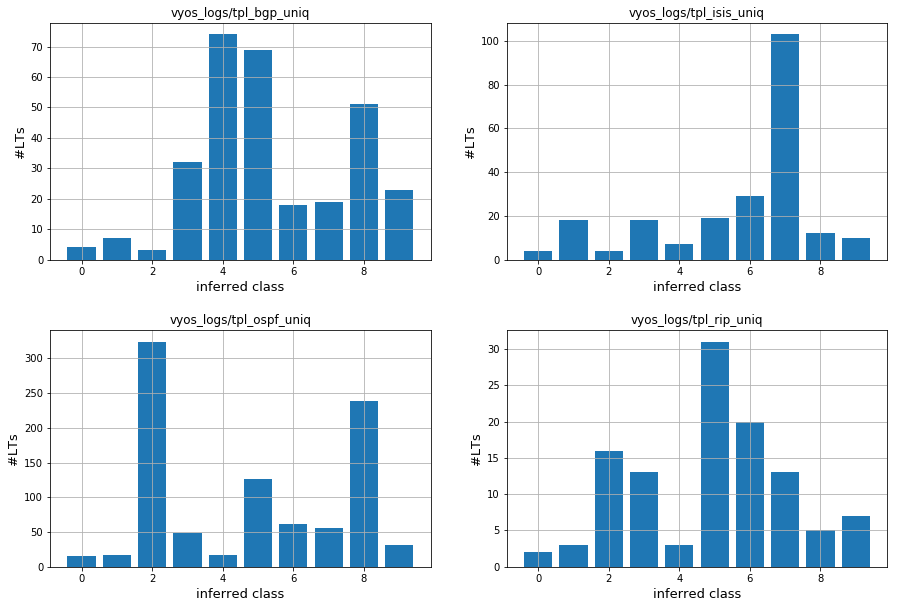

In [349]:
plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.3)
for e, (fn, i) in enumerate(results.items()):
    plt.subplot(2, 2, e+1)
    plt.title(fn)
    r = collections.Counter(i)
    y = [r[c]  if c in r else 0 for c in np.arange(10)]
    plt.bar(np.arange(10), y)
    plt.grid()
    plt.xlabel('inferred class', fontsize=13)
    plt.ylabel('#LTs', fontsize=13)
plt.show()


## 22クラス

In [312]:
for k,v in lt_per_infclass.items():
    print(k)
    for vv in v:
        if 'isis' in  vyos_string_to_corpus(vv):
            print("\t", vv.strip())
    print()

0

1
	 ISIS-Evt (**) Authentication failure ** from **
	 ISIS-Spf (**) L1 SPF needed, periodic SPF
	 ISIS-Spf (**) L2 SPF needed, periodic SPF
	 ISIS-Spf (**) L2 SPF needed, periodic SPF.
	 ISIS-Spf: isis_spftree_new Out of memory!
	 isis_multicast_join(): fd=**, reg_to=**, if_num=**, address = **:**:**:**:**:**
	 isis_multicast_join(): setsockopt(): **
	 isis_multicast_join(): setsockopt(): Accessing a corrupted shared library
	 isis_multicast_join(): setsockopt(): Address already in use
	 isis_multicast_join(): setsockopt(): Address family not supported by protocol
	 isis_multicast_join(): setsockopt(): Advertise error
	 isis_multicast_join(): setsockopt(): Argument list too long
	 isis_multicast_join(): setsockopt(): Attempting to link in too many shared libraries
	 isis_multicast_join(): setsockopt(): Bad address
	 isis_multicast_join(): setsockopt(): Bad file descriptor
	 isis_multicast_join(): setsockopt(): Bad font file format
	 isis_multicast_join(): setsockopt(): Bad message
	


2
	 isis_dynhn_insert(): out of memory!

3

4

5

6

7
	 ISIS-Upd (**): LSP ** received at level ** over circuit with externalDomain = true
	 isis_spf_process_lsp(): lsp with 0 seq_num - do not process
	 isis_spf_process_pseudo_lsp(): lsp with 0 seq_num - do not process

8
	 ISIS-Evt (**) system type change ** -> **
	 ISIS-Upd (**): (1) re-originating LSP ** new seq 0x**
	 ISIS-Upd (**): (2) re-originating LSP ** new seq 0x**
	 isis_vertex_new Out of memory!

9

10
	 Can't malloc isis circuit
	 Generating topology for ISIS
	 ISIS-Adj (**): Adjacency state change **->**: **
	 ISIS-Adj (**): Area mismatch, level ** IIH on **
	 ISIS-Adj (**): Interface level mismatch, **
	 ISIS-Adj (**): Rcvd L** LAN IIH from ** on **, cirType **, cirID **, length **
	 ISIS-Adj (**): Rcvd P2P IIH from (**), cir type **, cir id **, length **
	 ISIS-Adj (**): Sent L** LAN IIH on **, length **
	 ISIS-Adj (**): Sent P2P IIH on **, length **
	 ISIS-Adj (**): is type mismatch
	 ISIS-Adj (**): it's own IIH PDU 

	 isis_recv_pdu_bcast(): read() failed: Protocol error
	 isis_recv_pdu_bcast(): read() failed: Protocol family not supported
	 isis_recv_pdu_bcast(): read() failed: Protocol not available
	 isis_recv_pdu_bcast(): read() failed: Protocol not supported
	 isis_recv_pdu_bcast(): read() failed: Protocol wrong type for socket
	 isis_recv_pdu_bcast(): read() failed: RFS specific error
	 isis_recv_pdu_bcast(): read() failed: Read-only file system
	 isis_recv_pdu_bcast(): read() failed: Remote I/O error
	 isis_recv_pdu_bcast(): read() failed: Remote address changed
	 isis_recv_pdu_bcast(): read() failed: Required key not available
	 isis_recv_pdu_bcast(): read() failed: Resource deadlock avoided
	 isis_recv_pdu_bcast(): read() failed: Resource temporarily unavailable
	 isis_recv_pdu_bcast(): read() failed: Socket operation on non-socket
	 isis_recv_pdu_bcast(): read() failed: Socket type not supported
	 isis_recv_pdu_bcast(): read() failed: Software caused connection abort
	 isis_recv_pdu_bcast

	 isis_recv_pdu_bcast: getmsg failed: Socket type not supported
	 isis_recv_pdu_bcast: getmsg failed: Software caused connection abort
	 isis_recv_pdu_bcast: getmsg failed: Srmount error
	 isis_recv_pdu_bcast: getmsg failed: Stale file handle
	 isis_recv_pdu_bcast: getmsg failed: State not recoverable
	 isis_recv_pdu_bcast: getmsg failed: Streams pipe error
	 isis_recv_pdu_bcast: getmsg failed: Structure needs cleaning
	 isis_recv_pdu_bcast: getmsg failed: Success
	 isis_recv_pdu_bcast: getmsg failed: Text file busy
	 isis_recv_pdu_bcast: getmsg failed: Timer expired
	 isis_recv_pdu_bcast: getmsg failed: Too many levels of symbolic links
	 isis_recv_pdu_bcast: getmsg failed: Too many links
	 isis_recv_pdu_bcast: getmsg failed: Too many open files
	 isis_recv_pdu_bcast: getmsg failed: Too many open files in system
	 isis_recv_pdu_bcast: getmsg failed: Too many references: cannot splice
	 isis_recv_pdu_bcast: getmsg failed: Too many users
	 isis_recv_pdu_bcast: getmsg failed: Transport e

	 isis_recv_pdu_p2p(): read () failed: Value too large for defined data type
	 isis_recv_pdu_p2p(): read () failed: Wrong medium type

14
	 isis_zebra_add_route_ipv6: out of memory!
	 isis_zebra_route_del_ipv6: out of memory!

15
	 ISIS-Upd (**): LSP ** invalid LSP checksum 0x**
	 ISIS-Upd (**): refreshing our L** LSP **, seq 0x**, cksum 0x** lifetime **s
	 isis_dr_elect() adjdb == NULL
	 isis_run_dr(): run_dr_elect already set for l1
	 isis_run_dr(): run_dr_elect already set for l2

16
	 isis_multicast_join(): setsockopt(): .lib section in a.out corrupted

17
	 ISIS-Evt (**) Adjacency State change
	 isis_recv_packet_bcast(): fd **, recvfrom (): **
	 isis_recv_packet_bcast(): fd **, recvfrom (): .lib section in a.out corrupted
	 isis_recv_packet_bcast(): fd **, recvfrom (): Accessing a corrupted shared library
	 isis_recv_packet_bcast(): fd **, recvfrom (): Address already in use
	 isis_recv_packet_bcast(): fd **, recvfrom (): Address family not supported by protocol
	 isis_recv_packet


18
	 isis_recv_pdu_p2p(): protocol mismatch(): %X

19

20

21



In [313]:
for k,v in lt_per_infclass.items():
    print(k)
    for vv in v:
        if 'bgp' in  vyos_string_to_corpus(vv):
            print("\t", vv.strip())
    print()

0

1

2
	 ** [FSM] bgp_ignore called

3

4

5

6
	 ** [Error] BGP dynamic capability is not enabled
	 ** [Error] bgp_read_packet error: **
	 ** [Error] bgp_read_packet error: Accessing a corrupted shared library
	 ** [Error] bgp_read_packet error: Address already in use
	 ** [Error] bgp_read_packet error: Address family not supported by protocol
	 ** [Error] bgp_read_packet error: Advertise error
	 ** [Error] bgp_read_packet error: Argument list too long
	 ** [Error] bgp_read_packet error: Attempting to link in too many shared libraries
	 ** [Error] bgp_read_packet error: Bad address
	 ** [Error] bgp_read_packet error: Bad file descriptor
	 ** [Error] bgp_read_packet error: Bad font file format
	 ** [Error] bgp_read_packet error: Bad message
	 ** [Error] bgp_read_packet error: Block device required
	 ** [Error] bgp_read_packet error: Broken pipe
	 ** [Error] bgp_read_packet error: Can not access a needed shared library
	 ** [Error] bgp_read_packet error: Cannot allocate memory
	 ** [Er

	 [Error] BGP socket accept failed ()
	 bgp_socket: could not parse ip address **: .lib section in a.out corrupted
	 bgp_socket: could not parse ip address **: Accessing a corrupted shared library
	 bgp_socket: could not parse ip address **: Address already in use
	 bgp_socket: could not parse ip address **: Address family not supported by protocol
	 bgp_socket: could not parse ip address **: Advertise error
	 bgp_socket: could not parse ip address **: Argument list too long
	 bgp_socket: could not parse ip address **: Attempting to link in too many shared libraries
	 bgp_socket: could not parse ip address **: Bad address
	 bgp_socket: could not parse ip address **: Bad file descriptor
	 bgp_socket: could not parse ip address **: Bad font file format
	 bgp_socket: could not parse ip address **: Bad message
	 bgp_socket: could not parse ip address **: Block device required
	 bgp_socket: could not parse ip address **: Broken pipe
	 bgp_socket: could not parse ip address **: Can not acces

	 bgp_socket: could not parse ip address **: Too many users
	 bgp_socket: could not parse ip address **: Transport endpoint is already connected
	 bgp_socket: could not parse ip address **: Transport endpoint is not connected
	 bgp_socket: could not parse ip address **: Unknown error 41
	 bgp_socket: could not parse ip address **: Unknown error 58
	 bgp_socket: could not parse ip address **: Value too large for defined data type
	 bgp_socket: could not parse ip address **: Wrong medium type

10

11
	 ** [Event] Accepting BGP peer is deleted
	 ** [Event] Transfer accept BGP peer to real (state **)
	 bgp_bind: could not lower privs
	 bgp_bind: could not raise privs
	 bgp_connect_success peer's fd is negative value **
	 bgp_open_receive peer's fd is negative value **
	 bgp_read peer's fd is negative value **
	 bgp_start peer's fd is negative value **

12
	 [Event] BGP connection from host **

13

14
	 ** [Event] Accepting BGP peer delete

15
	 ** [Error] BGP route refresh is not enabled




21



In [314]:
for k,v in lt_per_infclass.items():
    print(k)
    for vv in v:
        if 'ospf' in  vyos_string_to_corpus(vv):
            print("\t", vv.strip())
    print()

0
	 ospf_abr_announce_aggregates(): Skipping announcement of BB aggregate into a transit area
	 ospf_abr_announce_aggregates(): Start
	 ospf_abr_announce_aggregates(): Stop
	 ospf_abr_announce_aggregates(): active range
	 ospf_abr_announce_aggregates(): discarding suppress-ranges
	 ospf_abr_announce_aggregates(): this is range: **/**
	 ospf_abr_announce_network_to_area(): Stop
	 ospf_abr_announce_network_to_area(): old summary approved
	 ospf_abr_announce_rtr(): Stop
	 ospf_abr_announce_rtr_to_area(): Stop
	 ospf_abr_announce_rtr_to_area(): old summary approved
	 ospf_abr_announce_stub_defaults(): Start
	 ospf_abr_announce_stub_defaults(): Stop
	 ospf_abr_nssa_am_elected: best electable ABR is: **
	 ospf_abr_nssa_am_elected: router ** asserts Nt
	 ospf_abr_nssa_check_status: checking area **
	 ospf_abr_nssa_check_status: elected translator
	 ospf_abr_nssa_check_status: never translate
	 ospf_abr_nssa_check_status: not ABR
	 ospf_abr_nssa_check_status: translate always
	 ospf_abr_nssa_t

	 ospf_opaque_lsa_reoriginate_schedule: Under blockade.
	 ospf_opaque_lsa_reoriginate_schedule: Unexpected LSA-type(**)
	 ospf_opaque_self_originated_lsa_received: Unexpected LSA-type(**)
	 ospf_opaque_type10_lsa_reoriginate_timer: No associated function?
	 ospf_opaque_type10_lsa_reoriginate_timer: Something wrong?
	 ospf_opaque_type11_lsa_reoriginate_timer: No associated function?
	 ospf_opaque_type11_lsa_reoriginate_timer: Something wrong?
	 ospf_opaque_type9_lsa_reoriginate_timer: No associated function?
	 ospf_opaque_type9_lsa_reoriginate_timer: Something wrong?
	 ospf_register_opaque_functab: Cannot get funclist for Type-** LSAs?
	 ospf_register_opaque_functab: Duplicated entry?: lsa_type(**), opaque_type(**)
	 ospf_register_opaque_functab: XMALLOC: **
	 ospf_summary_lsa_install(): SPF scheduled
	 ospf_mpls_te_new_if: XMALLOC: .lib section in a.out corrupted
	 ospf_mpls_te_new_if: XMALLOC: Accessing a corrupted shared library
	 ospf_mpls_te_new_if: XMALLOC: Address already in use


	 ospf_register_opaque_functab: XMALLOC: .lib section in a.out corrupted
	 ospf_register_opaque_functab: XMALLOC: Accessing a corrupted shared library
	 ospf_register_opaque_functab: XMALLOC: Address already in use
	 ospf_register_opaque_functab: XMALLOC: Address family not supported by protocol
	 ospf_register_opaque_functab: XMALLOC: Advertise error
	 ospf_register_opaque_functab: XMALLOC: Argument list too long
	 ospf_register_opaque_functab: XMALLOC: Attempting to link in too many shared libraries
	 ospf_register_opaque_functab: XMALLOC: Bad address
	 ospf_register_opaque_functab: XMALLOC: Bad file descriptor
	 ospf_register_opaque_functab: XMALLOC: Bad font file format
	 ospf_register_opaque_functab: XMALLOC: Bad message
	 ospf_register_opaque_functab: XMALLOC: Block device required
	 ospf_register_opaque_functab: XMALLOC: Broken pipe
	 ospf_register_opaque_functab: XMALLOC: Can not access a needed shared library
	 ospf_register_opaque_functab: XMALLOC: Cannot allocate memory
	 os


6
	 **: adjusting OSPF send buffer size to **
	 msg_read: OSPF API protocol version mismatch
	 ospf_apiserver_send_msg: Unknown message type **
	 *** sendmsg in ospf_write failed to **, id **, off **, len **, interface **, mtu **: Accessing a corrupted shared library

7
	 *** ospf_write_frags: sendmsg failed to **, id **, off **, len **, mtu ** failed with **
	 interface **: ospf_check_md5 bad sequence ** (expect **)
	 interface **: ospf_check_md5 no key **
	 ospf_lsa_install() got an lsa with seq 0x80000000 that was not self originated. Ignoring\n
	 ospf_write_frags: sent id **, off **, len ** to **\n
	 *** ospf_write_frags: sendmsg failed to **, id **, off **, len **, mtu ** failed with .lib section in a.out corrupted
	 *** ospf_write_frags: sendmsg failed to **, id **, off **, len **, mtu ** failed with Accessing a corrupted shared library
	 *** ospf_write_frags: sendmsg failed to **, id **, off **, len **, mtu ** failed with Address already in use
	 *** ospf_write_frags: sendmsg f

	 *** ospf_write_frags: sendmsg failed to **, id **, off **, len **, mtu ** failed with No space left on device
	 *** ospf_write_frags: sendmsg failed to **, id **, off **, len **, mtu ** failed with No such device
	 *** ospf_write_frags: sendmsg failed to **, id **, off **, len **, mtu ** failed with No such device or address
	 *** ospf_write_frags: sendmsg failed to **, id **, off **, len **, mtu ** failed with No such file or directory
	 *** ospf_write_frags: sendmsg failed to **, id **, off **, len **, mtu ** failed with No such process
	 *** ospf_write_frags: sendmsg failed to **, id **, off **, len **, mtu ** failed with Not a XENIX named type file
	 *** ospf_write_frags: sendmsg failed to **, id **, off **, len **, mtu ** failed with Not a directory
	 *** ospf_write_frags: sendmsg failed to **, id **, off **, len **, mtu ** failed with Numerical argument out of domain
	 *** ospf_write_frags: sendmsg failed to **, id **, off **, len **, mtu ** failed with Numerical result out of 

	 ospf_read_sock_init: socket: Key has been revoked
	 ospf_read_sock_init: socket: Key has expired
	 ospf_read_sock_init: socket: Key was rejected by service
	 ospf_read_sock_init: socket: Level 2 halted
	 ospf_read_sock_init: socket: Level 2 not synchronized
	 ospf_read_sock_init: socket: Level 3 halted
	 ospf_read_sock_init: socket: Level 3 reset
	 ospf_read_sock_init: socket: Link has been severed
	 ospf_read_sock_init: socket: Link number out of range
	 ospf_read_sock_init: socket: Machine is not on the network
	 ospf_read_sock_init: socket: Memory page has hardware error
	 ospf_read_sock_init: socket: Message too long
	 ospf_read_sock_init: socket: Multihop attempted
	 ospf_read_sock_init: socket: Name not unique on network
	 ospf_read_sock_init: socket: Network dropped connection on reset
	 ospf_read_sock_init: socket: Network is down
	 ospf_read_sock_init: socket: Network is unreachable
	 ospf_read_sock_init: socket: No CSI structure available
	 ospf_read_sock_init: socket: No X

	 ospf_sock_init: could not lower privs, Name not unique on network
	 ospf_sock_init: could not lower privs, Network dropped connection on reset
	 ospf_sock_init: could not lower privs, Network is down
	 ospf_sock_init: could not lower privs, Network is unreachable
	 ospf_sock_init: could not lower privs, No CSI structure available
	 ospf_sock_init: could not lower privs, No XENIX semaphores available
	 ospf_sock_init: could not lower privs, No anode
	 ospf_sock_init: could not lower privs, No buffer space available
	 ospf_sock_init: could not lower privs, No child processes
	 ospf_sock_init: could not lower privs, No data available
	 ospf_sock_init: could not lower privs, No locks available
	 ospf_sock_init: could not lower privs, No medium found
	 ospf_sock_init: could not lower privs, No message of desired type
	 ospf_sock_init: could not lower privs, No route to host
	 ospf_sock_init: could not lower privs, No space left on device
	 ospf_sock_init: could not lower privs, No such de

	 ospf_sock_init: could not raise privs, Level 3 reset
	 ospf_sock_init: could not raise privs, Link has been severed
	 ospf_sock_init: could not raise privs, Link number out of range
	 ospf_sock_init: could not raise privs, Machine is not on the network
	 ospf_sock_init: could not raise privs, Memory page has hardware error
	 ospf_sock_init: could not raise privs, Message too long
	 ospf_sock_init: could not raise privs, Multihop attempted
	 ospf_sock_init: could not raise privs, Name not unique on network
	 ospf_sock_init: could not raise privs, Network dropped connection on reset
	 ospf_sock_init: could not raise privs, Network is down
	 ospf_sock_init: could not raise privs, Network is unreachable
	 ospf_sock_init: could not raise privs, No CSI structure available
	 ospf_sock_init: could not raise privs, No XENIX semaphores available
	 ospf_sock_init: could not raise privs, No anode
	 ospf_sock_init: could not raise privs, No buffer space available
	 ospf_sock_init: could not raise

	 ospf_apiserver_new_if: interface ** not known to OSPFd?
	 ospf_apiserver_new_if: interface has no name?
	 ospf_apiserver_nsm_change
	 ospf_apiserver_opaque_lsa_new: ospf_lsa_data_new() ?
	 ospf_apiserver_opaque_lsa_new: ospf_lsa_new() ?
	 ospf_apiserver_opaque_lsa_new: stream_new failed
	 ospf_apiserver_originate1: ospf_lsa_install failed
	 ospf_apiserver_read: Unknown fd(**)
	 ospf_apiserver_read: read failed on fd=**, closing connection
	 ospf_apiserver_register_opaque_type: lsa_type(**)
	 ospf_apiserver_send_reply: msg_new failed
	 ospf_apiserver_serv_sock_family: listen: **
	 ospf_apiserver_sync_write: Unknown fd=**
	 ospf_apiserver_sync_write: write failed on fd=**
	 ospf_check_abr_status(): Start
	 ospf_check_abr_status(): new router flags: **
	 ospf_external_lsa_flush(): stop
	 ospf_ia_network_route(): add new route to **/**
	 ospf_ia_router_route(): adding the new route
	 ospf_ia_router_route(): considering **/**
	 ospf_ia_router_route(): skipping the new route
	 ospf_ia_rout

	 *** sendmsg in ospf_write failed to **, id **, off **, len **, interface **, mtu **: No buffer space available
	 *** sendmsg in ospf_write failed to **, id **, off **, len **, interface **, mtu **: No child processes
	 *** sendmsg in ospf_write failed to **, id **, off **, len **, interface **, mtu **: No data available
	 *** sendmsg in ospf_write failed to **, id **, off **, len **, interface **, mtu **: No locks available
	 *** sendmsg in ospf_write failed to **, id **, off **, len **, interface **, mtu **: No medium found
	 *** sendmsg in ospf_write failed to **, id **, off **, len **, interface **, mtu **: No message of desired type
	 *** sendmsg in ospf_write failed to **, id **, off **, len **, interface **, mtu **: No route to host
	 *** sendmsg in ospf_write failed to **, id **, off **, len **, interface **, mtu **: No space left on device
	 *** sendmsg in ospf_write failed to **, id **, off **, len **, interface **, mtu **: No such device
	 *** sendmsg in ospf_write failed t

	 ospf_apiserver_accept: accept: Key has been revoked
	 ospf_apiserver_accept: accept: Key has expired
	 ospf_apiserver_accept: accept: Key was rejected by service
	 ospf_apiserver_accept: accept: Level 2 halted
	 ospf_apiserver_accept: accept: Level 2 not synchronized
	 ospf_apiserver_accept: accept: Level 3 halted
	 ospf_apiserver_accept: accept: Level 3 reset
	 ospf_apiserver_accept: accept: Link has been severed
	 ospf_apiserver_accept: accept: Link number out of range
	 ospf_apiserver_accept: accept: Machine is not on the network
	 ospf_apiserver_accept: accept: Memory page has hardware error
	 ospf_apiserver_accept: accept: Message too long
	 ospf_apiserver_accept: accept: Multihop attempted
	 ospf_apiserver_accept: accept: Name not unique on network
	 ospf_apiserver_accept: accept: Network dropped connection on reset
	 ospf_apiserver_accept: accept: Network is down
	 ospf_apiserver_accept: accept: Network is unreachable
	 ospf_apiserver_accept: accept: No CSI structure available

	 ospf_apiserver_accept: connect: No route to host
	 ospf_apiserver_accept: connect: No space left on device
	 ospf_apiserver_accept: connect: No such device
	 ospf_apiserver_accept: connect: No such device or address
	 ospf_apiserver_accept: connect: No such file or directory
	 ospf_apiserver_accept: connect: No such process
	 ospf_apiserver_accept: connect: Not a XENIX named type file
	 ospf_apiserver_accept: connect: Not a directory
	 ospf_apiserver_accept: connect: Numerical argument out of domain
	 ospf_apiserver_accept: connect: Numerical result out of range
	 ospf_apiserver_accept: connect: Object is remote
	 ospf_apiserver_accept: connect: Operation already in progress
	 ospf_apiserver_accept: connect: Operation canceled
	 ospf_apiserver_accept: connect: Operation not permitted
	 ospf_apiserver_accept: connect: Operation not possible due to RF-kill
	 ospf_apiserver_accept: connect: Operation not supported
	 ospf_apiserver_accept: connect: Operation now in progress
	 ospf_apiser

	 ospf_apiserver_accept: getpeername: Operation not permitted
	 ospf_apiserver_accept: getpeername: Operation not possible due to RF-kill
	 ospf_apiserver_accept: getpeername: Operation not supported
	 ospf_apiserver_accept: getpeername: Operation now in progress
	 ospf_apiserver_accept: getpeername: Out of streams resources
	 ospf_apiserver_accept: getpeername: Owner died
	 ospf_apiserver_accept: getpeername: Package not installed
	 ospf_apiserver_accept: getpeername: Permission denied
	 ospf_apiserver_accept: getpeername: Protocol driver not attached
	 ospf_apiserver_accept: getpeername: Protocol error
	 ospf_apiserver_accept: getpeername: Protocol family not supported
	 ospf_apiserver_accept: getpeername: Protocol not available
	 ospf_apiserver_accept: getpeername: Protocol not supported
	 ospf_apiserver_accept: getpeername: Protocol wrong type for socket
	 ospf_apiserver_accept: getpeername: RFS specific error
	 ospf_apiserver_accept: getpeername: Read-only file system
	 ospf_apise

	 ospf_apiserver_accept: shutdown: RFS specific error
	 ospf_apiserver_accept: shutdown: Read-only file system
	 ospf_apiserver_accept: shutdown: Remote I/O error
	 ospf_apiserver_accept: shutdown: Remote address changed
	 ospf_apiserver_accept: shutdown: Required key not available
	 ospf_apiserver_accept: shutdown: Resource deadlock avoided
	 ospf_apiserver_accept: shutdown: Resource temporarily unavailable
	 ospf_apiserver_accept: shutdown: Socket operation on non-socket
	 ospf_apiserver_accept: shutdown: Socket type not supported
	 ospf_apiserver_accept: shutdown: Software caused connection abort
	 ospf_apiserver_accept: shutdown: Srmount error
	 ospf_apiserver_accept: shutdown: Stale file handle
	 ospf_apiserver_accept: shutdown: State not recoverable
	 ospf_apiserver_accept: shutdown: Streams pipe error
	 ospf_apiserver_accept: shutdown: Structure needs cleaning
	 ospf_apiserver_accept: shutdown: Success
	 ospf_apiserver_accept: shutdown: Text file busy
	 ospf_apiserver_accept: sh

	 ospf_apiserver_accept: socket: Too many links
	 ospf_apiserver_accept: socket: Too many open files
	 ospf_apiserver_accept: socket: Too many open files in system
	 ospf_apiserver_accept: socket: Too many references: cannot splice
	 ospf_apiserver_accept: socket: Too many users
	 ospf_apiserver_accept: socket: Transport endpoint is already connected
	 ospf_apiserver_accept: socket: Transport endpoint is not connected
	 ospf_apiserver_accept: socket: Unknown error 41
	 ospf_apiserver_accept: socket: Unknown error 58
	 ospf_apiserver_accept: socket: Value too large for defined data type
	 ospf_apiserver_accept: socket: Wrong medium type
	 ospf_apiserver_serv_sock_family: listen: .lib section in a.out corrupted
	 ospf_apiserver_serv_sock_family: listen: Accessing a corrupted shared library
	 ospf_apiserver_serv_sock_family: listen: Address already in use
	 ospf_apiserver_serv_sock_family: listen: Address family not supported by protocol
	 ospf_apiserver_serv_sock_family: listen: Advertis

	 ospf_apiserver_serv_sock_family: listen: Timer expired
	 ospf_apiserver_serv_sock_family: listen: Too many levels of symbolic links
	 ospf_apiserver_serv_sock_family: listen: Too many links
	 ospf_apiserver_serv_sock_family: listen: Too many open files
	 ospf_apiserver_serv_sock_family: listen: Too many open files in system
	 ospf_apiserver_serv_sock_family: listen: Too many references: cannot splice
	 ospf_apiserver_serv_sock_family: listen: Too many users
	 ospf_apiserver_serv_sock_family: listen: Transport endpoint is already connected
	 ospf_apiserver_serv_sock_family: listen: Transport endpoint is not connected
	 ospf_apiserver_serv_sock_family: listen: Unknown error 41
	 ospf_apiserver_serv_sock_family: listen: Unknown error 58
	 ospf_apiserver_serv_sock_family: listen: Value too large for defined data type
	 ospf_apiserver_serv_sock_family: listen: Wrong medium type

20
	 ospf_abr_announce_rtr_to_area(): 2.2
	 ospf_abr_announce_rtr_to_area(): flooding new version of summary
	 

In [282]:
## including 'set', 

for k,v in lt_per_infclass.items():
    print(k)
    for vv in v:
        print("\t", vv.strip())
    print()

0
	 
	 **
	 # Requests **
	 #**: **
	 **
	 ** **
	 ** Option length error
	 ** [FSM] Timer (connect timer expire)
	 ** [Update:SEND] **/** is filtered
	 ** bad OPEN, got AS4 capability, but AS4 set to 0
	 ** bad OPEN, got AS4 capability, but remote_as ** mismatch with 16bit 'myasn' ** in open
	 ** send UPDATE **/**
	 ** send UPDATE **/** **
	 ** send UPDATE **/** -- unreachable
	 ** send on **
	 ** sending KEEPALIVE
	 ** sendto failed: **
	 ** state -> unresponsive : no response yet to ping sent ** seconds ago
	 ** state -> up : echo response received after **.** seconds
	 **(**): set_nonblocking(**) failed
	 **/** filtered by distribute in
	 **/** filtered by distribute out
	 **/** is filtered by distribute out
	 **:
	 **: **
	 **: ** ** ** **
	 **: Attempt to ** out of bounds
	 **: Can't bind socket ** to ** port **: **
	 **: adjusting OSPF send buffer size to **
	 **: attempting to connect
	 **: check_connect: getsockopt failed: **
	 **: corruption detected: buffer queue empty, but 

	 can't set sockopt IPV6_MINHOPCNT to ** on socket **: Inappropriate ioctl for device
	 can't set sockopt IPV6_MINHOPCNT to ** on socket **: Input/output error
	 can't set sockopt IPV6_MINHOPCNT to ** on socket **: Interrupted system call
	 can't set sockopt IPV6_MINHOPCNT to ** on socket **: Interrupted system call should be restarted
	 can't set sockopt IPV6_MINHOPCNT to ** on socket **: Invalid argument
	 can't set sockopt IPV6_MINHOPCNT to ** on socket **: Invalid cross-device link
	 can't set sockopt IPV6_MINHOPCNT to ** on socket **: Invalid exchange
	 can't set sockopt IPV6_MINHOPCNT to ** on socket **: Invalid or incomplete multibyte or wide character
	 can't set sockopt IPV6_MINHOPCNT to ** on socket **: Invalid request code
	 can't set sockopt IPV6_MINHOPCNT to ** on socket **: Invalid request descriptor
	 can't set sockopt IPV6_MINHOPCNT to ** on socket **: Invalid slot
	 can't set sockopt IPV6_MINHOPCNT to ** on socket **: Is a directory
	 can't set sockopt IPV6_MINHOPCNT t

	 rtadv_send_packet: sendmsg ** (Cannot send after transport endpoint shutdown)
	 rtadv_send_packet: sendmsg ** (Channel number out of range)
	 rtadv_send_packet: sendmsg ** (Communication error on send)
	 rtadv_send_packet: sendmsg ** (Connection refused)
	 rtadv_send_packet: sendmsg ** (Connection reset by peer)
	 rtadv_send_packet: sendmsg ** (Connection timed out)
	 rtadv_send_packet: sendmsg ** (Destination address required)
	 rtadv_send_packet: sendmsg ** (Device not a stream)
	 rtadv_send_packet: sendmsg ** (Device or resource busy)
	 rtadv_send_packet: sendmsg ** (Directory not empty)
	 rtadv_send_packet: sendmsg ** (Disk quota exceeded)
	 rtadv_send_packet: sendmsg ** (Exchange full)
	 rtadv_send_packet: sendmsg ** (Exec format error)
	 rtadv_send_packet: sendmsg ** (File descriptor in bad state)
	 rtadv_send_packet: sendmsg ** (File exists)
	 rtadv_send_packet: sendmsg ** (File name too long)
	 rtadv_send_packet: sendmsg ** (File too large)
	 rtadv_send_packet: sendmsg ** (Fu

	 SMUX register message send failed: Illegal seek
	 SMUX register message send failed: Inappropriate ioctl for device
	 SMUX register message send failed: Input/output error
	 SMUX register message send failed: Interrupted system call
	 SMUX register message send failed: Interrupted system call should be restarted
	 SMUX register message send failed: Invalid argument
	 SMUX register message send failed: Invalid cross-device link
	 SMUX register message send failed: Invalid exchange
	 SMUX register message send failed: Invalid or incomplete multibyte or wide character
	 SMUX register message send failed: Invalid request code
	 SMUX register message send failed: Invalid request descriptor
	 SMUX register message send failed: Invalid slot
	 SMUX register message send failed: Is a directory
	 SMUX register message send failed: Is a named type file
	 SMUX register message send failed: Key has been revoked
	 SMUX register message send failed: Key has expired
	 SMUX register message send fail

	 error translating address **: Too many open files
	 error translating address **: Too many open files in system
	 error translating address **: Too many references: cannot splice
	 error translating address **: Too many users
	 error translating address **: Transport endpoint is already connected
	 error translating address **: Transport endpoint is not connected
	 error translating address **: Unknown error 41
	 error translating address **: Unknown error 58
	 error translating address **: Value too large for defined data type
	 error translating address **: Wrong medium type
	 select() error: Accessing a corrupted shared library
	 select() error: Address already in use
	 select() error: Address family not supported by protocol
	 select() error: Advertise error
	 select() error: Argument list too long
	 select() error: Attempting to link in too many shared libraries
	 select() error: Bad address
	 select() error: Bad file descriptor
	 select() error: Bad font file format
	 select() 

	 **: error: Unknown error 41 type=**(**), seq=**, pid=**
	 **: error: Unknown error 58 type=**(**), seq=**, pid=**
	 Can't lower privileges, .lib section in a.out corrupted
	 Can't lower privileges, Accessing a corrupted shared library
	 Can't lower privileges, Address already in use
	 Can't lower privileges, Address family not supported by protocol
	 Can't lower privileges, Advertise error
	 Can't lower privileges, Argument list too long
	 Can't lower privileges, Attempting to link in too many shared libraries
	 Can't lower privileges, Bad address
	 Can't lower privileges, Bad file descriptor
	 Can't lower privileges, Bad font file format
	 Can't lower privileges, Bad message
	 Can't lower privileges, Block device required
	 Can't lower privileges, Broken pipe
	 Can't lower privileges, Can not access a needed shared library
	 Can't lower privileges, Cannot allocate memory
	 Can't lower privileges, Cannot assign requested address
	 Can't lower privileges, Cannot exec a shared library 

	 NSM[**:**]: Down (PollIntervalTimer scheduled)
	 NSM[**:**]: State change ** -> ** (**)
	 NSM[**:**]: Timer (Inactivity timer expire)
	 NSM[**:**]: Timer (Poll timer expire)
	 NSM[**:**]: Timer (hello-reply timer expire)
	 Neighbor Event **: *1Way-Received*
	 Neighbor Event **: *2Way-Received*
	 Neighbor Event **: *AdjOK?*
	 Neighbor Event **: *InactivityTimer*
	 Neighbor not found, ignore
	 Neighbor state is 2-Way, ignore
	 No Linklocal address on **, defer originating
	 No nexthop, ignore
	 No retransmission scheduled, next interface
	 No such route ** to withdraw
	 Phase [**] hanging for ** seconds, aborting phased restart
	 Phased global restart has completed.
	 Phased restart: ** is now up.
	 Phased restart: ** restart job completed.
	 Phased restart: all routing daemons now down.
	 Phased restart: stopping all routing daemons.
	 Received is from the I/F, itself BDR, next interface
	 Route[**/**]: lookup, no such prefix
	 Route[**/**]: no such external path
	 SNMP access by area

	 Cannot create UDP socket: Disk quota exceeded
	 Cannot create UDP socket: Exchange full
	 Cannot create UDP socket: Exec format error
	 Cannot create UDP socket: File descriptor in bad state
	 Cannot create UDP socket: File exists
	 Cannot create UDP socket: File name too long
	 Cannot create UDP socket: File too large
	 Cannot create UDP socket: Function not implemented
	 Cannot create UDP socket: Host is down
	 Cannot create UDP socket: Identifier removed
	 Cannot create UDP socket: Illegal seek
	 Cannot create UDP socket: Inappropriate ioctl for device
	 Cannot create UDP socket: Input/output error
	 Cannot create UDP socket: Interrupted system call
	 Cannot create UDP socket: Interrupted system call should be restarted
	 Cannot create UDP socket: Invalid argument
	 Cannot create UDP socket: Invalid cross-device link
	 Cannot create UDP socket: Invalid exchange
	 Cannot create UDP socket: Invalid or incomplete multibyte or wide character
	 Cannot create UDP socket: Invalid request

	 Can't listen to unix socket **: Block device required
	 Can't listen to unix socket **: Broken pipe
	 Can't listen to unix socket **: Can not access a needed shared library
	 Can't listen to unix socket **: Cannot allocate memory
	 Can't listen to unix socket **: Cannot assign requested address
	 Can't listen to unix socket **: Cannot exec a shared library directly
	 Can't listen to unix socket **: Cannot send after transport endpoint shutdown
	 Can't listen to unix socket **: Channel number out of range
	 Can't listen to unix socket **: Communication error on send
	 Can't listen to unix socket **: Connection refused
	 Can't listen to unix socket **: Connection reset by peer
	 Can't listen to unix socket **: Connection timed out
	 Can't listen to unix socket **: Destination address required
	 Can't listen to unix socket **: Device not a stream
	 Can't listen to unix socket **: Device or resource busy
	 Can't listen to unix socket **: Directory not empty
	 Can't listen to unix socket 

	 getifaddrs(): Inappropriate ioctl for device
	 getifaddrs(): Input/output error
	 getifaddrs(): Interrupted system call
	 getifaddrs(): Interrupted system call should be restarted
	 getifaddrs(): Invalid argument
	 getifaddrs(): Invalid cross-device link
	 getifaddrs(): Invalid exchange
	 getifaddrs(): Invalid or incomplete multibyte or wide character
	 getifaddrs(): Invalid request code
	 getifaddrs(): Invalid request descriptor
	 getifaddrs(): Invalid slot
	 getifaddrs(): Is a directory
	 getifaddrs(): Is a named type file
	 getifaddrs(): Key has been revoked
	 getifaddrs(): Key has expired
	 getifaddrs(): Key was rejected by service
	 getifaddrs(): Level 2 halted
	 getifaddrs(): Level 2 not synchronized
	 getifaddrs(): Level 3 halted
	 getifaddrs(): Level 3 reset
	 getifaddrs(): Link has been severed
	 getifaddrs(): Link number out of range
	 getifaddrs(): Machine is not on the network
	 getifaddrs(): Memory page has hardware error
	 getifaddrs(): Message too long
	 getifaddrs(): 

	 **(**): connect failed: Channel number out of range
	 **(**): connect failed: Communication error on send
	 **(**): connect failed: Connection refused
	 **(**): connect failed: Connection reset by peer
	 **(**): connect failed: Connection timed out
	 **(**): connect failed: Destination address required
	 **(**): connect failed: Device not a stream
	 **(**): connect failed: Device or resource busy
	 **(**): connect failed: Directory not empty
	 **(**): connect failed: Disk quota exceeded
	 **(**): connect failed: Exchange full
	 **(**): connect failed: Exec format error
	 **(**): connect failed: File descriptor in bad state
	 **(**): connect failed: File exists
	 **(**): connect failed: File name too long
	 **(**): connect failed: File too large
	 **(**): connect failed: Function not implemented
	 **(**): connect failed: Host is down
	 **(**): connect failed: Identifier removed
	 **(**): connect failed: Illegal seek
	 **(**): connect failed: Inappropriate ioctl for device
	 **(**): co

	 SIOCGIFCONF: Bad font file format
	 SIOCGIFCONF: Bad message
	 SIOCGIFCONF: Block device required
	 SIOCGIFCONF: Broken pipe
	 SIOCGIFCONF: Can not access a needed shared library
	 SIOCGIFCONF: Cannot allocate memory
	 SIOCGIFCONF: Cannot assign requested address
	 SIOCGIFCONF: Cannot exec a shared library directly
	 SIOCGIFCONF: Cannot send after transport endpoint shutdown
	 SIOCGIFCONF: Channel number out of range
	 SIOCGIFCONF: Communication error on send
	 SIOCGIFCONF: Connection refused
	 SIOCGIFCONF: Connection reset by peer
	 SIOCGIFCONF: Connection timed out
	 SIOCGIFCONF: Destination address required
	 SIOCGIFCONF: Device not a stream
	 SIOCGIFCONF: Device or resource busy
	 SIOCGIFCONF: Directory not empty
	 SIOCGIFCONF: Disk quota exceeded
	 SIOCGIFCONF: Exchange full
	 SIOCGIFCONF: Exec format error
	 SIOCGIFCONF: File descriptor in bad state
	 SIOCGIFCONF: File exists
	 SIOCGIFCONF: File name too long
	 SIOCGIFCONF: File too large
	 SIOCGIFCONF: Function not implemented

	 isis_recv_pdu_bcast: getmsg failed: Resource temporarily unavailable
	 isis_recv_pdu_bcast: getmsg failed: Socket operation on non-socket
	 isis_recv_pdu_bcast: getmsg failed: Socket type not supported
	 isis_recv_pdu_bcast: getmsg failed: Software caused connection abort
	 isis_recv_pdu_bcast: getmsg failed: Srmount error
	 isis_recv_pdu_bcast: getmsg failed: Stale file handle
	 isis_recv_pdu_bcast: getmsg failed: State not recoverable
	 isis_recv_pdu_bcast: getmsg failed: Streams pipe error
	 isis_recv_pdu_bcast: getmsg failed: Structure needs cleaning
	 isis_recv_pdu_bcast: getmsg failed: Success
	 isis_recv_pdu_bcast: getmsg failed: Text file busy
	 isis_recv_pdu_bcast: getmsg failed: Timer expired
	 isis_recv_pdu_bcast: getmsg failed: Too many levels of symbolic links
	 isis_recv_pdu_bcast: getmsg failed: Too many links
	 isis_recv_pdu_bcast: getmsg failed: Too many open files
	 isis_recv_pdu_bcast: getmsg failed: Too many open files in system
	 isis_recv_pdu_bcast: getmsg faile

	 **: access to socket ** denied: Level 2 halted
	 **: access to socket ** denied: Level 2 not synchronized
	 **: access to socket ** denied: Level 3 halted
	 **: access to socket ** denied: Level 3 reset
	 **: access to socket ** denied: Link has been severed
	 **: access to socket ** denied: Link number out of range
	 **: access to socket ** denied: Machine is not on the network
	 **: access to socket ** denied: Memory page has hardware error
	 **: access to socket ** denied: Message too long
	 **: access to socket ** denied: Multihop attempted
	 **: access to socket ** denied: Name not unique on network
	 **: access to socket ** denied: Network dropped connection on reset
	 **: access to socket ** denied: Network is down
	 **: access to socket ** denied: Network is unreachable
	 **: access to socket ** denied: No CSI structure available
	 **: access to socket ** denied: No XENIX semaphores available
	 **: access to socket ** denied: No anode
	 **: access to socket ** denied: No buff

	 vtysh_accept: could not set vty socket ** to non-blocking, Identifier removed, closing
	 vtysh_accept: could not set vty socket ** to non-blocking, Illegal seek, closing
	 vtysh_accept: could not set vty socket ** to non-blocking, Inappropriate ioctl for device, closing
	 vtysh_accept: could not set vty socket ** to non-blocking, Input/output error, closing
	 vtysh_accept: could not set vty socket ** to non-blocking, Interrupted system call should be restarted, closing
	 vtysh_accept: could not set vty socket ** to non-blocking, Interrupted system call, closing
	 vtysh_accept: could not set vty socket ** to non-blocking, Invalid argument, closing
	 vtysh_accept: could not set vty socket ** to non-blocking, Invalid cross-device link, closing
	 vtysh_accept: could not set vty socket ** to non-blocking, Invalid exchange, closing
	 vtysh_accept: could not set vty socket ** to non-blocking, Invalid or incomplete multibyte or wide character, closing
	 vtysh_accept: could not set vty socket

### eval

- 外れたやつについて，調査

In [ ]:
for a,b in lt_per_cat.items():
    print(a, len(b))

In [ ]:
## show results

inf_per_cat = {}
for cat,lts in lt_per_cat.items():
    print(cat)
    inf_per_cat[cat] = []
    for lt in lts:
        c = list(collections.Counter([word2id[w] for w in string_to_corpus(lt, max_len=7)]).items())
        topic_dist, word_topic, word_topic_dist = junos_lda[c]
        inf_topic = np.argmax(np.array([t[1] for t in topic_dist]))
        inf_per_cat[cat].append(inf_topic)
        print("\t", inf_topic, ",", lt)

In [ ]:
## show detailed results

inf_per_cat = {}
for cat,lts in lt_per_cat.items():
    print(cat)
    inf_per_cat[cat] = []
    for lt in lts:
        print(lt)
        c = list(collections.Counter([word2id[w] for w in string_to_corpus(lt, max_len=7)]).items())
        topic_dist, word_topic, word_topic_dist = junos_lda[c]
        inf_topic = np.argmax(np.array([t[1] for t in topic_dist]))
        inf_per_cat[cat].append(inf_topic)
        print("\t", inf_topic)
        print("\t", inf_topic_words[inf_topic])
        print("\t"+"-"*10)
        for w in word_topic_dist:
            print("\t", id2word[w[0]], w[1])
        print()

In [ ]:
## 推定トピック別のLT

lt_per_inf_topic = {}
for i in range(40):
    lt_per_inf_topic[i] = []
    
for ltid, data in raw_lt.items():
    lt = data['lt']
        
    c = list(collections.Counter([word2id[w] for w in string_to_corpus(lt, max_len=7)]).items())
    topic_dist, word_topic, word_topic_dist = junos_lda[c]
    inf_topic = np.argmax(np.array([t[1] for t in topic_dist]))
    
    lt_per_inf_topic[inf_topic].append((lt, string_to_corpus(lt, max_len=7)))
    
for inf_topic, lts in lt_per_inf_topic.items():
    print(inf_topic, inf_topic_words[inf_topic])
    
    for lt in lts:
        print("\t", lt[0], "\t",  lt[1])
    print()

In [ ]:
cat_per_inf = {}
for cat,lts in lt_per_cat.items():
    for lt in lts:
        c = list(collections.Counter([word2id[w] for w in string_to_corpus(lt, max_len=7)]).items())
        topic_dist, word_topic, word_topic_dist = junos_lda[c]
        inf_topic = np.argmax(np.array([t[1] for t in topic_dist]))
        if inf_topic in cat_per_inf:
            cat_per_inf[inf_topic].append((lt, cat))
        else:
            cat_per_inf[inf_topic] = [(lt, cat)]

In [ ]:
import pprint
pprint.pprint(cat_per_inf[14])

# VyOS + JUNOS

- 混ぜてみる．
- 分離するのかどうか

In [ ]:
def remove_symbols(value):
    return value.replace('-', '').replace('+', '').replace("'",'').replace('>','').replace('<','').replace('=','').replace('(', '').replace(')', '').replace('[', '').replace(']', '').replace('**', '').replace(':', '').replace(',', '').replace("_", " ")

def string_to_corpus(lt, max_len=None):
    words = [remove_symbols(t) for t in lt.split()]
    split_words = []
    for w in words:
        if len(w.split()) > 1: # さらに分割できる場合
            split_words.extend(w.split())
        else:
            split_words.append(w)
    split_words = [t.lower() for t in split_words if t != '']
    if max_len != None:
        split_words = split_words[:max_len] # 前方のみ残す

    return split_words

def remove_error_words(split_words):
    for error_word in error_words:
        if error_word == split_words[-len(error_word):]:
            return split_words[:-len(error_word)] ## 前方の単語が抜かれてしまわないようにする
    return split_words

In [ ]:
## JUNOS vocab

with open("./lt.json", "r") as f:
    raw_lt = json.load(f)
    
lt_per_cat = {}
for ltid, value in raw_lt.items():
    if value['cat'] not in lt_per_cat:
        lt_per_cat[value['cat']] = [value['lt']]
    else:
        lt_per_cat[value['cat']].append(value['lt'])
        
words_per_cat = dict()
for cat, lts in lt_per_cat.items():
    corpus = []
    for lt in lts:
        words = [remove_symbols(t) for t in lt.split()]
        split_words = []
        for w in words:
            if len(w.split()) > 1: # さらに分割できる場合
                split_words.extend(w.split())
            else:
                split_words.append(w)
        split_words = [t.lower() for t in split_words if t != '']
        corpus.extend(split_words)
    words_per_cat[cat] = corpus
    
junos_all_words = list(set([word for cat, words in words_per_cat.items() for word in words]))
junos_word2id = {w:i for i, w in enumerate(junos_all_words)}
junos_id2word = {v:k for k,v in junos_word2id.items()}

In [ ]:
## VyOS vocab

with open("./vyos_logs/tpl_all_uniq", "r") as f:
    raw_vyos = f.readlines()

words_per_lt = []
for lt in raw_vyos:
    words = [remove_symbols(t) for t in lt.split()]
    split_words = []
    for w in words:
        if len(w.split()) > 1: # さらに分割できる場合
            split_words.extend(w.split())
        else:
            split_words.append(w)
    split_words = [t.lower() for t in split_words if t != '']
    words_per_lt.append(split_words)
    
## エラー文の抽出
error_words = []

for lt in raw_vyos[2599:2733]:
    words = [remove_symbols(t) for t in lt.split()]
    split_words = []
    for w in words:
        if len(w.split()) > 1: # さらに分割できる場合
            split_words.extend(w.split())
        else:
            split_words.append(w)
    split_words = [t.lower() for t in split_words if t != '']
    
    split_words = [w for w in split_words][5:]
    error_words.append(split_words)
    
vy_all_words = list(set([word for words in words_per_lt for word in words]))
vy_word2id = {w:i for i, w in enumerate(vy_all_words)}
vy_id2word = {v:k for k,v in vy_word2id.items()}

In [ ]:
## merge word dict

all_words = list(set(junos_all_words + vy_all_words))
word2id = {w:i for i, w in enumerate(all_words)}
id2word = {v:k for k,v in word2id.items()}

In [ ]:
## generate JUNOS corpus

corpus = []
for cat, lts in lt_per_cat.items():
    for lt in lts:
        words = [remove_symbols(t) for t in lt.split()]
        split_words = []
        for w in words:
            if len(w.split()) > 1: # さらに分割できる場合
                split_words.extend(w.split())
            else:
                split_words.append(w)
        split_words = [t.lower() for t in split_words if t != '']
        split_words = split_words[:10] # 前方のみ残す
        lt_word_id_cnt = collections.Counter([word2id[w] for w in split_words])
        corpus.append([(tid, cnt) for tid, cnt in lt_word_id_cnt.items()])
        
# 単語のカウント
word_cnt = {}
for wid, cnt in sorted(collections.Counter([c[0] for s in corpus for c in s]).items(), key= lambda x: x[1])[::-1]:
    word_cnt[id2word[wid]] = cnt
    

STOP_WORDS = [word2id[i] for i in ['and', 'of', 'from', 'to', 'in', 'on', 'is', 'for', 'or']]
    
tmp = []
eval_corpus = []
eval_corpus_ltids = []

for ltid, i in enumerate(corpus):
    if word2id['ui'] not in [j[0] for j in i]: # uiを弾く(550番)
        i = [j for j in i if j[0] not in STOP_WORDS]
        tmp.append(tuple(sorted(i)))
        eval_corpus.append(i)
        eval_corpus_ltids.append(ltid)
    
set_corpus = list(set(tmp))

In [ ]:
## generate VyOS corpus

vy_corpus = []
vy_tmp_corpus = []
for lt in raw_vyos:
    words = [remove_symbols(t) for t in lt.split()]
    split_words = []
    for w in words:
        if len(w.split()) > 1: # さらに分割できる場合
            split_words.extend(w.split())
        else:
            split_words.append(w)
    split_words = [t.lower() for t in split_words if t != '']
    split_words = remove_error_words(split_words)
    vy_tmp_corpus.append(split_words)
    
for i in range(18145,18279):
    vy_tmp_corpus[i] = ['cant',
      'setsockopt',
      'ip',
      'add',
      'membership',
      'fd',
      'addr',
      'ifindex',
      'alldrouters']

for i in range(18279,18413):
    vy_tmp_corpus[i] = ['cant',
      'setsockopt',
      'ip',
      'add',
      'membership',
      'fd',
      'addr',
      'ifindex',
      'allspfrouters']
    
uniq_corpus = list(set([tuple(i) for i in vy_tmp_corpus]))
for split_words in uniq_corpus:
    lt_word_id_cnt = collections.Counter([word2id[w] for w in split_words])
    vy_corpus.append([(tid, cnt) for tid, cnt in lt_word_id_cnt.items()])
    
# 単語のカウント
vy_word_cnt = {}
for wid, cnt in sorted(collections.Counter([c[0] for s in vy_corpus for c in s]).items(), key= lambda x: x[1])[::-1]:
    vy_word_cnt[id2word[wid]] = cnt
    
stop_words = ["failed", "is", "cant", "not", "error", "to", "on", "of", "by", "for", "a", "from", "the", "with", "\\n", 'or', 'in']
    
## stop word 除去
vy_eval_corpus = []
for c in vy_corpus:
    vy_eval_corpus.append([cc for cc in c if id2word[cc[0]] not in stop_words])

In [ ]:
error_words

In [ ]:
for i in uniq_corpus:
    print(" ".join(i))

In [ ]:
merged_corpus = vy_eval_corpus + set_corpus

In [ ]:
lda = gensim.models.ldamodel.LdaModel(
                                      corpus=merged_corpus,
                                      chunksize=5,
                                      num_topics=40, 
                                      id2word=id2word, 
                                      minimum_probability=1e-8, 
                                      #gamma_threshold=1e-5,
                                      #eval_every=10,
                                      iterations=100,
#                                       alpha='auto', 
#                                       eta='auto', 
                                      decay=1.0,
                                      passes=1,
                                      per_word_topics=True)

In [ ]:
inf_topic_words = {}
for topic in range(lda.num_topics):
    print(topic, [id2word[i[0]] for i in lda.get_topic_terms(topic)])
    inf_topic_words[topic] = [id2word[i[0]] for i in lda.get_topic_terms(topic)]

In [ ]:
## show results

inf_per_cat = {}
for cat,lts in lt_per_cat.items():
    print(cat)
    inf_per_cat[cat] = []
    for lt in lts:
        c = list(collections.Counter([word2id[w] for w in string_to_corpus(lt, max_len=7)]).items())
        topic_dist, word_topic, word_topic_dist = lda[c]
        inf_topic = np.argmax(np.array([t[1] for t in topic_dist]))
        inf_per_cat[cat].append(inf_topic)
        print("\t", inf_topic, ",", lt)

In [ ]:
## plot per category graphs
## x-axis: infered topic
## y-axis: cnt

plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-whitegrid')
cvs = []

for cat, res in inf_per_cat.items():
    plt.figure(figsize=(15, 5))
    plt.title(cat)
    y = collections.Counter(res)
    y = [y[i] if i in y else 0 for i in range(40)]
    plt.bar(np.arange(40), y, color="#85C1E9")
    plt.xticks(np.arange(40))
    minY = 5 if max(y) < 5 else max(y)+1
    plt.ylim(0, minY)
    plt.show()

    print(np.array(y).std())
    cvs.append((cat, np.array(y).std()/np.array(y).mean()))

In [ ]:
## 推定トピック別のLT

lt_per_inf_topic = {}
for i in range(40):
    lt_per_inf_topic[i] = []
    
for ltid, data in raw_lt.items():
    lt = data['lt']
        
    c = list(collections.Counter([word2id[w] for w in string_to_corpus(lt, max_len=10)]).items())
    topic_dist, word_topic, word_topic_dist = lda[c]
    inf_topic = np.argmax(np.array([t[1] for t in topic_dist]))
    
    lt_per_inf_topic[inf_topic].append(lt)
    
    
for split_words in uniq_corpus:

    lt_word_id_cnt = collections.Counter([word2id[w] for w in split_words])
    c = [(tid, cnt) for tid, cnt in lt_word_id_cnt.items()]    
    c = [cc for cc in c if id2word[cc[0]] not in stop_words]
    
    topic_dist, word_topic, word_topic_dist = lda[c]
    inf_topic = np.argmax(np.array([t[1] for t in topic_dist]))
    
    lt_per_inf_topic[inf_topic].append(" ".join(split_words))
    
for inf_topic, lts in lt_per_inf_topic.items():
    print(inf_topic, inf_topic_words[inf_topic])
    
    for lt in lts:
        print("\t", lt)
    print()

In [ ]:
with open('20180919_result.txt', 'w') as f:
    for inf_topic, lts in lt_per_inf_topic.items():
        f.write(str(inf_topic))
        f.write("[" + " ".join(inf_topic_words[inf_topic]) + "]" )
        f.write("\n")

        for lt in lts:
            f.write("\t" + lt)
            f.write("\n")
        f.write("\n")